In [1]:
import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append('/home/monteirod/script/utils/')
import utils as u
import matplotlib as m

from scipy.stats import bootstrap
import statsmodels.api as sm
import xesmf as xe
import matplotlib.dates as mdates
import sys
from scipy import stats
import datetime
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import xarray as xr
import geopandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as m
import regionmask
import pandas as pd
import geopandas
import warnings
from glob import glob
from uncertainties import unumpy
import dask
from dask.diagnostics import ProgressBar
warnings.filterwarnings('ignore')
# import hvplot.xarray  # noqa
import cmasher as cmr


# Define variables and load CNRM-AROME experiments

In [2]:
## Path
shp_path = '/cnrm/cen/users/NO_SAVE/monteirod/Shapefile/Alpine_Convention_Perimeter_2018_v2_4326/'
shp = geopandas.read_file(shp_path)

data_path = '/cnrm/cen/users/NO_SAVE/monteirod/EXPE_AROME/'
output_path = '/home/monteirod/tmp/EXPE_AROME/Article_AROME/'

## List of experiments to load
# ls_EXPE = {'D95_3L':'D95-3L','ES_DIFF':'ES-DIF','ES_DIFF_UP_PATCH':'3-PATCHS','ES_DIFF_UP_PATCH_GFLUX':'GFLUX','ES_DIFF_UP_PATCH_GFLUX_WSN1':'WSN-1','ES_DIFF_sg_LSOC_PATCH':'ES-DIF-OPT','ES_DIFF_OPT_spin_up':'Spin-up'}
ls_EXPE = {'D95_3L':'D95-3L','ES_DIFF':'ES-DIF','ES_DIFF_sg_LSOC_PATCH':'ES-DIF-OPT'}

# Dictionnary of variables / colors
ls_name_color = {'MODIS':'gray','CSNOW':'gray','OBS':'black','D95_3L':"#e49b30",'ES_DIFF':"#1dabe6",'ES_DIFF_UP_PATCH':'#79c08a','ES_DIFF_UP_PATCH_GFLUX':'#ab50d8','ES_DIFF_UP_PATCH_GFLUX_WSN1':'#865e52','ES_DIFF_sg_LSOC_PATCH':'#006c00','ES_DIFF_OPT_RIL':'darkgrey'}

years = ['2018','2019','2020']
var = { 'ts': 'Surface temperature',
 'snd': 'Snow depth',
 'swe': 'Snow water equivalent',
 'snct': 'Snow cover fraction',
 'atot': 'Total albedo',
 'tas': 'Temperature at 2m',
 'pr' : 'Precipitation',
 'ts': 'Surface temperature',
 'tp2': 'Soil temperature 5cm',
 'tp3': 'Soil temperature 10cm',
 'dswe': 'SWE variation',
 'snmlt': 'Snowmelt',
 'hfgr': 'Ground heat flux \n (surface energy balance)',
 'hfle': 'Latent heat flux',
 'hfsc': 'Sensible heat flux',
 'rtot': 'Net radiation \n (radiative balance)',
 'lwdn': 'Downward longwave',
 'swdn': 'Downward shortwave',
 'lwun': 'Upward longwave',
 'swun': 'Upward shortwave',
 'z0s': 'Roughness length surface',
 'z0hs': 'Roughness length surface H ?',
}


In [149]:
## Load ls_var variables for each experiments of ls_EXPE in a dask array

ls_var = list(var.keys())
ls_var = ['snd']
ds = {}

oro = xr.load_dataset('/cnrm/cen/users/NO_SAVE/monteirod/EXPE_AROME/orog_aro_era5.nc').set_coords(['lat','lon'])
soil_type = xr.load_dataset('/cnrm/cen/users/NO_SAVE/monteirod/EXPE_AROME/ES_DIFF_UP_PATCH/fx/ARO_ALP3_fraction_of_each_patch.nc')
import time 

for i in list(ls_EXPE.keys()):
    print(i)
        
    start = time.time()

    if i == 'D95_3L':
        ds[i] = xr.merge([xr.open_mfdataset(data_path+i+'/day/'+j+'_*.nc', chunks = 'auto', combine = 'nested',concat_dim='time', coords = 'minimal', data_vars='minimal')[j].sel(time = slice('01-01-'+years[0],'12-31-'+years[-1])).chunk(chunks={'y': 35, 'x': 35, 'time': -1}) for j in [x for x in ls_var if x != 'tp3']]+[oro]+[soil_type], join = 'override', compat = 'override').set_coords('ZS')
    else:
        ds[i] = xr.merge([xr.open_mfdataset(data_path+i+'/day/'+j+'_*.nc', chunks = 'auto', combine = 'nested',concat_dim='time', coords = 'minimal', data_vars='minimal')[j].sel(time = slice('01-01-'+years[0],'12-31-'+years[-1])).chunk(chunks={'y': 35, 'x': 35, 'time': -1}) for j in ls_var]+[oro]+[soil_type], join = 'override', compat = 'override').set_coords('ZS')

    end = time.time()
    print(end - start)


D95_3L
12.570665121078491
ES_DIFF
12.88464641571045
ES_DIFF_sg_LSOC_PATCH
14.233909606933594


# Section 3.1 : Point-scale evaluation of snow depth values over the 2018-2019 winter

In [130]:
## Load observational dataset

years = ['2018','2019']

data_path = '/cnrm/cen/users/NO_SAVE/monteirod/Reference_Dataset/'

obs_snd = xr.load_dataset(data_path+'SND_OBS/OBS_Matiu/snd_Alps_2018_2020.nc')[['snd']]

### Create experiments datasets with only grid points at observation location (save as a netcdf)

In [9]:
incr_lat = 2.5/(40000/360)
def incr_lon(lat):
    return 2.5/((40000/360)*np.cos(np.deg2rad(lat)))

oro_aro = xr.load_dataset('/cnrm/cen/users/NO_SAVE/monteirod/EXPE_AROME/orog_aro_era5.nc').set_coords(['lat','lon'])

ls_y,ls_x = [], []
ls_name = []

## Get the list of x, y index corresponding AROME dimension (here, we remove 2 points possibility)
for j in range(0,len(obs_snd.Station_Name)):
    
    i_index = oro_aro.ZS.where((oro_aro.lon > obs_snd.lon[j] - incr_lon(obs_snd.lat[j])/2)*(oro_aro.lon < obs_snd.lon[j] + incr_lon(obs_snd.lat[j])/2)*(oro_aro.lat > obs_snd.lat[j] -incr_lat/2)*(oro_aro.lat < obs_snd.lat[j] + incr_lat/2))
    if np.shape((np.where(~np.isnan(i_index)))) == (2,1):
        ls_y.append(int(np.where(~np.isnan(i_index))[0]))
        ls_x.append(int(np.where(~np.isnan(i_index))[1]))
        ls_name.append(str(i_index.Station_Name.values))

## Make the selection over initial ds at obs points
out_repertory = '/cnrm/cen/users/NO_SAVE/monteirod/EXPE_AROME/'

for j in list(ls_EXPE.keys()):
    print(j)
    i_data = ds[j].isel(x = xr.DataArray(ls_x, dims = 'Station_Name'),y = xr.DataArray(ls_y, dims = 'Station_Name'))
    i_data['Station_Name'] = ls_name
    write_job = i_data.to_netcdf(out_repertory+j+'/'+j+'_ARO_obs_matiu_patch.nc', compute=False)
    # write_job = i_data.to_netcdf(out_repertory+j+'/'+j+'_ARO_obs_matiu.nc', compute=False)

    # Write the job with a progress bar view
    with ProgressBar():
        print(j)
        write_job.compute()

ES_DIFF_OPT_RIL
ES_DIFF_OPT_RIL
[########################################] | 100% Completed | 94.51 s


### Load CNRM-AROME experiments at observation location

In [132]:
## This code only keep the grid points that encompasses the location of observations
## It is design to speed up the process of loading each experiments by creating a subset

shp_path = '/cnrm/cen/users/NO_SAVE/monteirod/Shapefile/Alpine_Convention_Perimeter_2018_v2_4326/'
shp = geopandas.read_file(shp_path)

data_path = '/cnrm/cen/users/NO_SAVE/monteirod/EXPE_AROME/'
output_path = '/home/monteirod/tmp/EXPE_AROME/'

ds_point = {}

## Resample daily (already done before ?)
for i in list(ls_EXPE.keys()):
    print(i)
    ds_point[i] = xr.load_dataset(data_path+i+'/'+i+'_ARO_obs_matiu.nc').resample(time = '1D').mean()
    ds_point[i]['snd'] = ds_point[i]['snd']*100
    
## Add patch snd
# ls_EXPE_patch = {'ES_DIFF_UP_PATCH':'3-PATCHS','ES_DIFF_UP_PATCH_GFLUX':'GFLUX','ES_DIFF_UP_PATCH_GFLUX_WSN1':'WSN-1','ES_DIFF_sg_LSOC_PATCH':'ES-DIF-OPT'}
# ls_EXPE_patch = {'ES_DIFF_sg_LSOC_PATCH':'ES-DIF-OPT'}
# for i in list(ls_EXPE_patch.keys()):
#     print(i)
#     ds_point[i] = xr.merge([ds_point[i],xr.load_dataset(data_path+i+'/'+i+'_ARO_obs_matiu_patch.nc').resample(time = '1D').mean()],compat= 'override')
    
    
## Remove high and short breakup in the series (what are the origin of them ?)
# for i in list(ls_EXPE.keys()):
#     for j in  ['hfgr','hfsc','hfle','rtot','swun','swdn','lwdn','lwun']:
#         ds_point[i][j] = ds_point[i][j].where((ds_point[i][j].diff(dim = 'time') < 300)).where((np.abs(ds_point[i][j]) < 500))


## Subsel matiu obs
obs_snd = obs_snd.snd.drop_duplicates(dim = 'Station_Name').to_dataset()
obs_snd = obs_snd.sel(Station_Name = np.unique(ds_point['D95_3L'].Station_Name))

D95_3L
ES_DIFF


## Figures

### Pre-treatment : Elevation mismatch and forest cover

In [133]:
## Remove points with more than 150m mismatch

for j in list(ls_EXPE.keys()):
    print(j)
    #remove duplicates index
    _, index = np.unique(ds_point[j]['Station_Name'], return_index=True)
    ds_point[j] = ds_point[j].isel(Station_Name = index)
    #remove duplicates index
    ds_point[j] = ds_point[j].set_coords(['P1','P2','P3'])
    ds_point[j] = ds_point[j].where(np.abs(ds_point[j].ZS - obs_snd.ZS) < 150, drop = True)
    
ds_point['OBS'] = obs_snd.sel(Station_Name = ds_point['D95_3L'].Station_Name)

## Remove points with more than XX% forest in ARO 
# (making the assumption that most of the in situ measurements are performed in open sites) 

ds_NO_HVEG = {}

for j in list(ls_EXPE.keys()):
    print(j)
    ds_NO_HVEG[j] = ds_point[j].where((ds_point[j].P2 < 0.75), drop = True)

## Subsel Matiu obs
ds_NO_HVEG['OBS'] = ds_point['OBS'].sel(Station_Name = ds_NO_HVEG['D95_3L'].Station_Name)


## Expand the dimension by elevations categories
ds_used = ds_NO_HVEG
var = 'snd'

ds_alt = {}
ls_alt = np.arange(-150,3600,300)
for i in ['OBS']+list(ls_EXPE.keys()):
    print(i)
    ds_alt[i] = u.applied_mask_from_shp(ds_used[i],shp_path,'lat','lon').squeeze()
    ds_alt[i] = u.per_alt(ds_alt[i], ls_alt).dropna(dim = 'Station_Name', how = 'all')

D95_3L
ES_DIFF
D95_3L
ES_DIFF


### Section 2.6.1 : Map location and distribution of In-situ snow depth observations+


KeyboardInterrupt



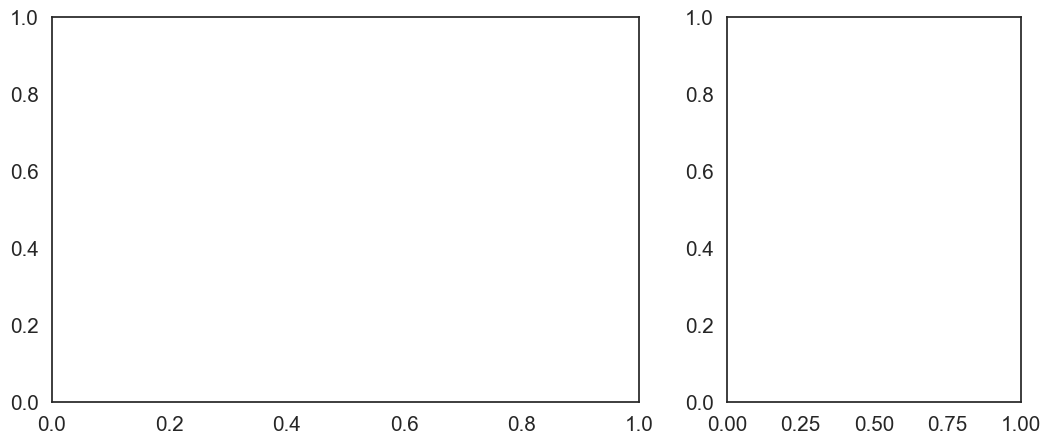

In [13]:
## Plot the map 

from matplotlib.gridspec import GridSpec

sns.set(font_scale = 1.35)
sns.set_style('white')

terrain_mod = cmr.get_sub_cmap('terrain', 0., 0.85)

fig = plt.figure(figsize = (12.5,5))
gs = GridSpec(1, 2, width_ratios=[2,1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

m2 = Basemap(llcrnrlon=4,llcrnrlat=43,urcrnrlon=17.,urcrnrlat=49, epsg = 4326, lat_0 = 43.5, lon_0 = 5, resolution = 'h', ax = ax1)
m2.drawcountries(linewidth = 0.5)
m2.drawcoastlines(linewidth = 0.5)
m2.shadedrelief()

# Plot the location of observations and shapefile boundaries
shp.plot(ax=ax1,color='white', edgecolor='black', linewidth =1)
im = m2.scatter(ds_alt['OBS'].lon,ds_alt['OBS'].lat,c = ds_alt['OBS'].ZS, cmap = terrain_mod, s = 7, vmin = 0, vmax = 3000)

fig.colorbar(im,ax = ax1, orientation = 'horizontal', label = 'Elevation (m)', fraction = 0.07,pad=0.01)

## Plot the repartition of obs along elevation bands
ax2.barh(ds_alt['D95_3L'].middle_slices_ZS.astype(int).astype(str),ds_alt['D95_3L'].count(dim = ['Station_Name']).mean(dim = 'time')[var])
ax2.set_ylabel('Elevation (m)')
ax2.set_xlabel('Number of stations')
ax2.grid(True)
ax2.set_ylim('0','3300')
if var == 'swe':
    fig.suptitle("Locations of the in situ snow water equivalent stations",y=1.0)
elif var == 'snd':
    fig.suptitle("Locations of the in situ snow depth measurements",y=1.0)
    
ax3 = ax2.twiny()

mnt = xr.load_dataset('/cnrm/cen/users/NO_SAVE/monteirod/Reference_Dataset/DEM/MNT100m_4326.nc').rename({ 'Band1':'ZS'})                                                                         
mnt = u.applied_mask_from_shp(mnt, shp_path, 'lat','lon').mean(dim = 'region')
mnt = u.per_alt(mnt,  np.arange(-150,5100,300))
freq = mnt.count(dim = ['lat','lon'])
freq = (freq/freq.sum(dim = 'middle_slices_ZS'))

ax3.plot(freq.ZS*100,freq.middle_slices_ZS.astype(int).astype(str), ls = ':', lw= 3, color = 'k', label = 'Reference DEM')
ax3.set_xlim(0,25)
ax3.set_xlabel('Frequency distribution of elevation (%)')

ax3.legend()

plt.savefig(output_path+'Repartition_of_SND_obs_per_elevation.pdf', bbox_inches= 'tight')

### Section 3.1 : Mean time series per elevation bands

In [136]:
patch = False
form = 'article'
    
## Case where you kick out P2 

if patch == True:
    for i in list(ls_EXPE_patch.keys()):
        ds_NO_HVEG[i][var] = (ds_NO_HVEG[i][var+'p1']*ds_NO_HVEG[i]['P1'])/(ds_NO_HVEG[i]['P1'] + ds_NO_HVEG[i]['P3']) + (ds_NO_HVEG[i][var+'p3']*ds_NO_HVEG[i]['P3'])/(ds_NO_HVEG[i]['P1']+ds_NO_HVEG[i]['P3'])

# Create the dataframe
time_slice = ['10-01-2018','08-31-2019']
# choosen_alt = list(reversed([600,900,1200,1800,2400,2700]))

if form == 'article':
    choosen_alt = list(reversed([900,1500,2100,2700]))
elif form == 'all':
    choosen_alt = list(reversed([300,600,900,1200,1500,1800,2100,2400,2700,3000]))

## Df no spatial mean (use to count)
df = []
for i in range(0,len(list(ds_alt.values()))):
    df_i = ds_alt[list(ds_alt.keys())[i]].sel(time = slice(time_slice[0],time_slice[1])).sel(middle_slices_ZS = choosen_alt).to_dataframe().reset_index().dropna()
    df.append(df_i)
df = pd.concat(df, keys = list(ds_alt.keys()))
df = df.reset_index().rename(columns = {'level_0':'Dataset'})


## Calculate mean score
ls_metrics = ['MEAN','ME','MAE','CORRELATION']

reference = ds_alt['OBS'].sel(time = slice(time_slice[0],time_slice[1])).mean(dim = 'Station_Name')
for i in range(0,len(list(ds_alt.values()))):

    # Mean values of each datasets
    ds_alt[list(ds_alt.keys())[i]]['MEAN'] = (ds_alt[list(ds_alt.keys())[i]][var]).mean(dim = 'Station_Name').mean(dim = 'time')
    # Mean errors (ME)
    ds_alt[list(ds_alt.keys())[i]]['ME'] = (ds_alt[list(ds_alt.keys())[i]][var].mean(dim = 'Station_Name') - reference[var]).mean(dim = 'time')
    # Mean absolute errors (MAE)
    ds_alt[list(ds_alt.keys())[i]]['MAE'] = (np.abs(ds_alt[list(ds_alt.keys())[i]][var].mean(dim = 'Station_Name') - reference[var])).mean(dim = 'time')
    # Correlation
    ds_alt[list(ds_alt.keys())[i]]['CORRELATION'] = xr.corr(ds_alt[list(ds_alt.keys())[i]][var].mean(dim = 'Station_Name'),reference[var], dim = 'time')


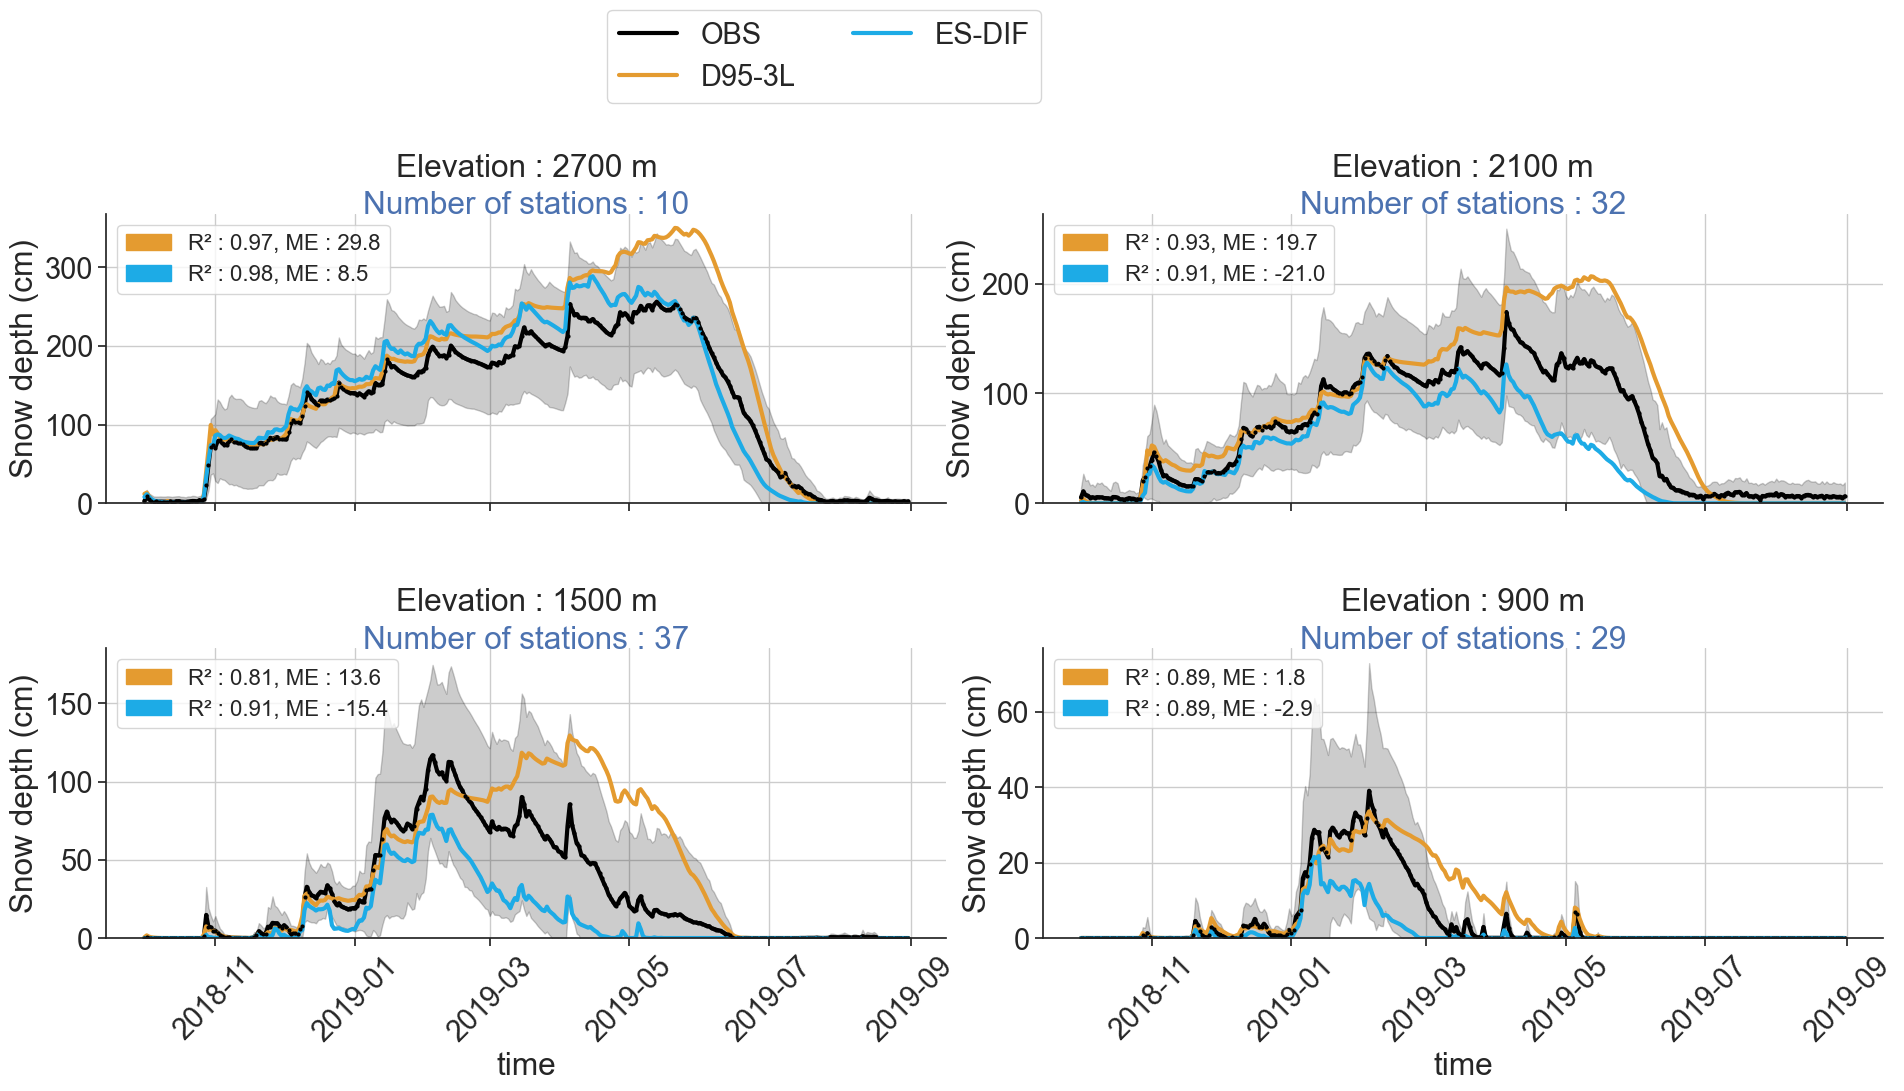

In [137]:
import matplotlib.patches as mpatches

sns.set(font_scale = 1.9)
sns.set_style("ticks")



if form == 'article':
    g = sns.relplot(data=df, x="time", y=var, hue = 'Dataset', col_order = choosen_alt,col = 'middle_slices_ZS',
                kind ='line', palette = ls_name_color, col_wrap=2 ,facet_kws={'sharey': False, 'sharex': True},
                linewidth = 3,height=4.5, aspect=2.2, alpha = 1, ci = None)

elif form == 'all':
    g = sns.relplot(data=df, x="time", y=var, hue = 'Dataset', col_order = choosen_alt,col = 'middle_slices_ZS',
                kind ='line', palette = ls_name_color, col_wrap=2 ,facet_kws={'sharey': False, 'sharex': True},
                linewidth = 3,height=4, aspect=2.5, alpha = 1, ci = None)

sns.move_legend(g, "upper left", bbox_to_anchor=(0.28, 1.17), ncol = 2, frameon = True, labels = ['OBS']+list(ls_EXPE.values()), title = None)

def show_counts(color, data):
    ax = plt.gca()
    ax.text(0.5, 1, 'Number of stations : '+str(int(len(data[data['Dataset'] == 'D95_3L'])/len(np.unique(data[data['Dataset'] == 'D95_3L']['time'])))), ha='center', color=color, transform=ax.transAxes)
g.map_dataframe(show_counts)
g.set_titles("Elevation : {col_name} m", y=1.1)

# Hghlight the observation line
axes = g.axes.flatten()
ref = df[df['Dataset']=='OBS']

for i in range(0,len(axes)): 
    ref_i = ref[ref['middle_slices_ZS'] == choosen_alt[i]]
    # select the data for the region
    sns.lineplot(data=ref_i, x='time', y=var, ax=axes[i], lw=None ,color = 'black', marker='o',markeredgecolor = "None",markersize = 3,ci = 'sd' ,linestyle = '',legend = None)
    patchlist = []
    for j in list(ls_EXPE.keys()):
        ls_name_color[j]
        patchlist.append(mpatches.Patch(color=ls_name_color[j] , label='R² : '+str(np.around(ds_alt[j].CORRELATION.sel(middle_slices_ZS = choosen_alt[i]).values,decimals = 2))
                                                                        +', ME : '+str(np.around(ds_alt[j].ME.sel(middle_slices_ZS = choosen_alt[i]).values,decimals = 1))))
    
    axes[i].legend(loc = 'upper left',handles=patchlist,prop={'size': 16})

for ax in g.axes.flat:
    ax.grid(True)
    ax.set_ylim(0)
    if var == 'snd':
        ax.set_ylabel('Snow depth (cm)')
    elif var == 'swe':
        ax.set_ylabel('Snow water equivalent (mm)')
    
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.subplots_adjust(hspace=0.5)

# plt.savefig(output_path+'Time_series_scores_alt_patch'+form+'_'+dataset+'.pdf', bbox_inches= 'tight')
# plt.savefig(output_path+'Time_series_scores_alt_patch'+form+'_'+dataset+'_all_EXPE.pdf', bbox_inches= 'tight')
plt.savefig(output_path+'Time_series_scores_alt_patch'+form+'_'+dataset+'_only_firstss.pdf', bbox_inches= 'tight')

# Section 3.2 : Snow cover duration evaluation using MODIS remote sensing data

### Load MODIS resample over CNRM-AROME mesh grid and CNRM-AROME experiments : Pre-treatment

In [3]:
data_path = '/cnrm/cen/users/NO_SAVE/monteirod/Reference_Dataset/'
shp_path = '/cnrm/cen/users/NO_SAVE/monteirod/Shapefile/Alpine_Convention_Perimeter_2018_v2_4326/'

MODIS = xr.load_dataset(data_path+'MOD10A1_NSIDC/netCDF/EXPE_AROME/MOD10A1_NDSI_ARO_20180101-20201231.nc')

In [4]:
## Compute MODIS SCD/SOD/MOD based on NDSI

MODIS_scd = MODIS['NDSI'].resample(time = 'A-SEP', closed = 'left',label = 'left').map(u.lcscd, threshold = 20).isel(time = slice(1,-1))
MODIS_scd = u.applied_mask_from_shp(MODIS_scd,shp_path,'lat','lon').squeeze()
MODIS_scd['sod'] = (['time']+['y','x'],[(mdates.date2num(MODIS_scd['sod'].sel(time = str(j))) - (np.datetime64(str(int(MODIS_scd.sel(time = str(j)).time.dt.year.values))+'-09-01','D') - np.datetime64(mdates.get_epoch(),'D')).astype(int))[0] for j in MODIS_scd.time.dt.year.values])
MODIS_scd['mod'] = (['time']+['y','x'],[(mdates.date2num(MODIS_scd['mod'].sel(time = str(j))) - (np.datetime64(str(int(MODIS_scd.sel(time = str(j)).time.dt.year.values))+'-09-01','D') - np.datetime64(mdates.get_epoch(),'D')).astype(int))[0] for j in MODIS_scd.time.dt.year.values])

In [ ]:
## Load and calculates snow cover duration based on CNRM-AROME experiments snow depth

yr_start = '2018'
yr_end = '2020'

ds_scd = {}
for i in ls_EXPE:
    print(i)
    i_data = ds[i].snd.resample(time = 'A-SEP', closed = 'left',label = 'left').map(u.lcscd, threshold = 0.01).isel(time = slice(1,-1)).load()
    ds_scd[i] = u.applied_mask_from_shp(i_data,shp_path,'lat','lon').squeeze()
    ds_scd[i]['sod'] = (['time']+['y','x'],[(mdates.date2num(ds_scd[i]['sod'].sel(time = str(j))) - (np.datetime64(str(int(ds_scd[i].sel(time = str(j)).time.dt.year.values))+'-09-01','D') - np.datetime64(mdates.get_epoch(),'D')).astype(int))[0] for j in ds_scd[i].time.dt.year.values])
    ds_scd[i]['mod'] = (['time']+['y','x'],[(mdates.date2num(ds_scd[i]['mod'].sel(time = str(j))) - (np.datetime64(str(int(ds_scd[i].sel(time = str(j)).time.dt.year.values))+'-09-01','D') - np.datetime64(mdates.get_epoch(),'D')).astype(int))[0] for j in ds_scd[i].time.dt.year.values])


### Section 2.6.2 : Boxplot and Map of the Snow cover duration MODIS 

In [ ]:
ls_alt = np.arange(450,3600,300)

modis_scd_alt = u.per_alt(MODIS_scd['scd'], ls_alt).rename({'time':'season'})
modis_scd_alt['season'] = ['2018-2019','2019-2020']

df = modis_scd_alt.to_dataframe().reset_index().drop(columns = ['x','y']).dropna()

## Boxplot

choosen_alt = [900,1500,2100,2700]
df_i = df[df['middle_slices_ZS'].isin(choosen_alt)]

sns.set(font_scale = 1.35)
sns.set_style("ticks")

g = sns.catplot(data=df_i,x ='scd',y = 'middle_slices_ZS',orient = 'h', hue = 'season',order = reversed(np.unique(df_i['middle_slices_ZS'])), kind = 'box',facet_kws={'sharex': True,'legend_out':True},showfliers=False,color = 'darkgrey', medianprops=dict(color="silver", linewidth =1.5),n_boot = 10000,linewidth = 0.8, height = 5, aspect = 0.9)
sns.move_legend(g,loc = 'center right',ncol = 1,title="Season", frameon=True)
# title
# new_title = 'Configurations'
# g._legend.set_title(new_title)
g.set_titles("Surface type : {col_name}")

# Labelled and grid
for ax in g.axes.flat:
    ax.grid(True, axis='both')
    ax.set_ylabel('Elevation (m)')
    ax.set_xlabel('Snow cover duration (days)')
    ax.axvline(0, ls='--', color = 'k', lw = 1.5)
    ax.set_yticklabels(np.array(list(reversed(np.unique(df_i['middle_slices_ZS'])))).astype(int))

plt.savefig(output_path+'boxplot_elevational_distribution_scd_MODIS_2018-2020_season.pdf', bbox_inches = 'tight')

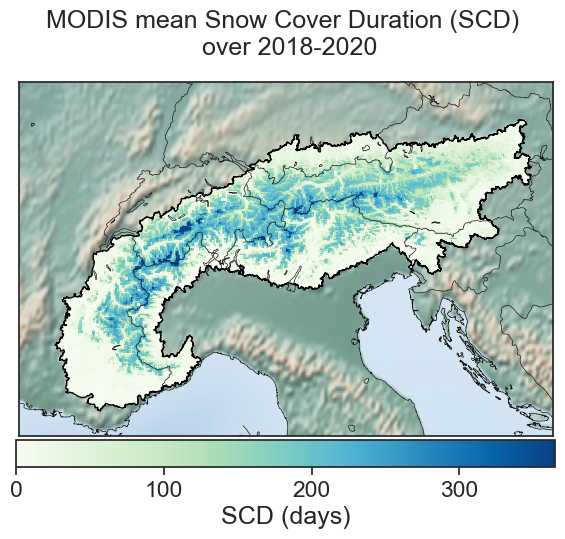

In [14]:
## SCD MODIS map for two years

fig, ax = plt.subplots(1,2,figsize = (10,5))

sns.set(font_scale = 1.2)
sns.set_style("white")


for i in range(0,len(MODIS_scd.time)):
    m2 = Basemap(llcrnrlon=4,llcrnrlat=43,urcrnrlon=17.,urcrnrlat=49, epsg = 4326, lat_0 = 43.5, lon_0 = 5, resolution = 'h', ax = ax[i])
    m2.drawcountries(linewidth = 0.5)
    m2.drawcoastlines(linewidth = 0.5)
    m2.shadedrelief()
    smap = m2.pcolor(MODIS_scd.lon,MODIS_scd.lat,MODIS_scd.scd.sel(time = str(int(MODIS_scd.time.dt.year[i]))).mean(dim = 'time'),vmin = 0,vmax = 365,cmap = 'GnBu')    

    # Boundaries of the shapefile
    shp.plot(ax=ax[i],color='None', edgecolor='black', linewidth =1)

    # Limits of the map and legend size
    ax[i].set( ylim = (43,49),xlim =(4,17), xticks = [], yticks = [])
    ax[i].set_title('MODIS Snow Cover Duration (SCD) \n over '+str(int(MODIS_scd.time.dt.year[i]))+'-'+str(int(MODIS_scd.time.dt.year[i])+1), pad=20, fontsize=14)


fig.colorbar(smap,ax = list(fig.axes), orientation = 'horizontal', label = ('Snow cover duration (days)'), fraction = 0.05, pad = 0.05)


plt.savefig(output_path+'Map_SCD_MODIS_ARO_2018-2019_and_2019-2020.png', bbox_inches = 'tight',dpi = 300)

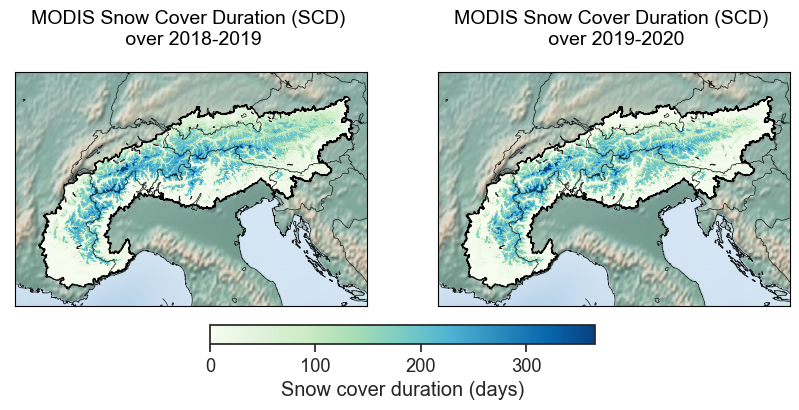

In [5]:
## SCD MODIS map for two years

fig, ax = plt.subplots(1,2,figsize = (10,5))

sns.set(font_scale = 1.2)
sns.set_style("white")


for i in range(0,len(MODIS_scd.time)):
    m2 = Basemap(llcrnrlon=4,llcrnrlat=43,urcrnrlon=17.,urcrnrlat=49, epsg = 4326, lat_0 = 43.5, lon_0 = 5, resolution = 'h', ax = ax[i])
    m2.drawcountries(linewidth = 0.5)
    m2.drawcoastlines(linewidth = 0.5)
    m2.shadedrelief()
    smap = m2.pcolor(MODIS_scd.lon,MODIS_scd.lat,MODIS_scd.scd.sel(time = str(int(MODIS_scd.time.dt.year[i]))).mean(dim = 'time'),vmin = 0,vmax = 365,cmap = 'GnBu')    

    # Boundaries of the shapefile
    shp.plot(ax=ax[i],color='None', edgecolor='black', linewidth =1)

    # Limits of the map and legend size
    ax[i].set( ylim = (43,49),xlim =(4,17), xticks = [], yticks = [])
    ax[i].set_title('MODIS Snow Cover Duration (SCD) \n over '+str(int(MODIS_scd.time.dt.year[i]))+'-'+str(int(MODIS_scd.time.dt.year[i])+1), pad=20, fontsize=14)


fig.colorbar(smap,ax = list(fig.axes), orientation = 'horizontal', label = ('Snow cover duration (days)'), fraction = 0.05, pad = 0.05)


plt.savefig(output_path+'Map_SCD_MODIS_ARO_2018-2019_and_2019-2020.png', bbox_inches = 'tight',dpi = 300)

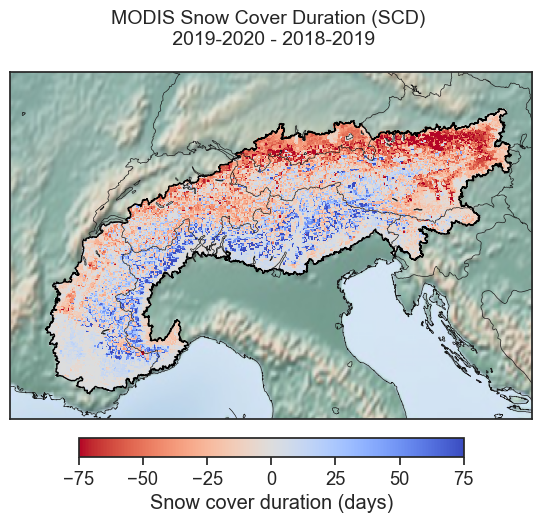

In [32]:
## Difference between the two years of snow cover duration

fig, ax = plt.subplots(1,1,figsize = (10,5))

sns.set(font_scale = 1.2)
sns.set_style("white")

m2 = Basemap(llcrnrlon=4,llcrnrlat=43,urcrnrlon=17.,urcrnrlat=49, epsg = 4326, lat_0 = 43.5, lon_0 = 5, resolution = 'h', ax = ax)
m2.drawcountries(linewidth = 0.5)
m2.drawcoastlines(linewidth = 0.5)
m2.shadedrelief()
smap = m2.pcolor(MODIS_scd.lon,MODIS_scd.lat,(MODIS_scd.scd.sel(time = str(int(MODIS_scd.time.dt.year[1]))).squeeze() - MODIS_scd.scd.sel(time = str(int(MODIS_scd.time.dt.year[0]))).squeeze()),vmin = -75,vmax = 75,cmap = 'coolwarm_r')    

# Boundaries of the shapefile
shp.plot(ax=ax,color='None', edgecolor='black', linewidth =1)

# Limits of the map and legend size
ax.set( ylim = (43,49),xlim =(4,17), xticks = [], yticks = [])
ax.set_title('MODIS Snow Cover Duration (SCD) \n 2019-2020 - 2018-2019', pad=20, fontsize=14)

fig.colorbar(smap,ax = ax, orientation = 'horizontal', label = ('Snow cover duration (days)'), fraction = 0.05, pad = 0.05)
plt.savefig(output_path+'Map_SCD_MODIS_ARO_DIFF_2018-2020.png', bbox_inches = 'tight',dpi = 300)

### Section 3.2 : Maps of the Delta SCD CNRM-AROME - MODIS

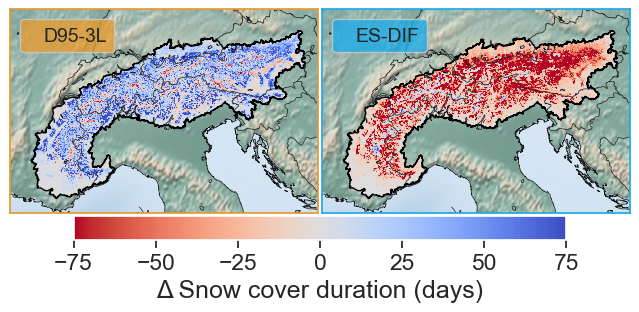

In [ ]:
## Panel map 

all_expe = False

var = 'scd'
ds_used = ds_scd

sns.set_style("white")

if all_expe == True:
    fig, ax = plt.subplots(2,3,figsize = (12,6.2), sharex = True, sharey = True)
    plt.subplots_adjust(wspace=0.02, hspace=0.)

else:
    fig, ax = plt.subplots(1,3,figsize = (12,3.2), sharex = True, sharey = True)
    plt.subplots_adjust(wspace=0.015, hspace=0.0)
    
sns.set(font_scale = 1.5)

for i, ax in enumerate(fig.axes):
    if i < 7:
    # Map background
        m2 = Basemap(llcrnrlon=4,llcrnrlat=43,urcrnrlon=17.,urcrnrlat=49, epsg = 4326, lat_0 = 43.5, lon_0 = 5, resolution = 'h', ax = ax)
        m2.drawcountries(linewidth = 0.5)
        m2.drawcoastlines(linewidth = 0.5)
        m2.shadedrelief()

        smap = m2.pcolor(ds_used[list(ds_used.keys())[i]].lon,ds_used[list(ds_used.keys())[i]].lat,ds_used[list(ds_used.keys())[i]][var].sel(time = slice(yr_start,yr_end)).mean(dim = 'time').squeeze() - MODIS_scd[var].sel(time = slice(yr_start,yr_end)).mean(dim = 'time').squeeze(),vmin = -75,vmax = 75,cmap = 'coolwarm_r', label = list(ls_EXPE.values())[i])    

        # Boundaries of the shapefile
        shp.plot(ax=ax,color='None', edgecolor='black', linewidth =1)

        # Limits of the map and legend size
        ax.set( ylim = (43,49),xlim =(4,17), xticks = [], yticks = [])
        ax.legend(prop={'size': 14}, handlelength=0, loc = 'upper left',fontsize = 100,facecolor=ls_name_color[list(ls_EXPE.keys())[i]], framealpha=0.8)
        for spine in ax.spines.values():
            spine.set_edgecolor(ls_name_color[list(ls_EXPE.keys())[i]])
            
fig.colorbar(smap,ax = list(fig.axes), orientation = 'horizontal', label = ('Δ Snow cover duration (days)'), fraction = 0.1, pad = 0.01)

if all_expe == True:
    plt.savefig(output_path+'Panel_'+var+'_'+'all_EXPE_'+yr_start+'-'+yr_end+'.png', bbox_inches = 'tight', dpi = 300)
else:
    plt.savefig(output_path+'Panel_'+var+'_'+yr_start+'-'+yr_end+'.png', bbox_inches = 'tight', dpi = 300)

### Section 3.2 : Boxplot of the delta SCD CNRM-AROME - MODIS

In [146]:
### Prepare boxplot 

ls_alt = np.arange(450,3600,300)

var = 'scd'
ds_shaped = {}

for i in list(ls_EXPE.keys()):
    print(i)
    ds_shaped[i] = u.per_alt((ds_scd[i].sel(time = slice(yr_start,yr_end)).mean(dim = 'time') -  MODIS_scd.sel(time = slice(yr_start,yr_end)).mean(dim = 'time')),ls_alt)
    
# Create the dataframe
df = []
thesh_veg = 0.75
ls_veg = ['All','P1','P2','P3','mixte']
ls_veg_name = ['All','No veg','High veg','Low Veg','Mixte']

for j in ls_veg:
    print(j)
    df_j = []
    for i in range(0,len(list(ds_shaped.values()))):
        if j == 'All':
            i_data = ds_shaped[list(ds_shaped.keys())[i]][var]
        elif j == 'mixte':
            i_data = ds_shaped[list(ds_shaped.keys())[i]][var].where((soil_type['P1'] < thesh_veg)*(soil_type['P2'] < thesh_veg)*(soil_type['P3'] < thesh_veg))            
        else:
            i_data = ds_shaped[list(ds_shaped.keys())[i]][var].where(soil_type[j] >= thesh_veg)
    
        df_i = i_data.to_dataframe().reset_index().drop(columns = ['x','y']+['ZS']).dropna()
        df_j.append(df_i)
    df_j = pd.concat(df_j, keys = list(ds_shaped.keys()))
    df.append(df_j.reset_index().rename(columns = {'level_0':'Dataset'}))

df = pd.concat(df, keys = ls_veg_name).drop(columns = 'level_1')
df = df.reset_index().rename(columns = {'level_0':'veg_type'})

D95_3L
ES_DIFF
All
P1
P2
P3
mixte


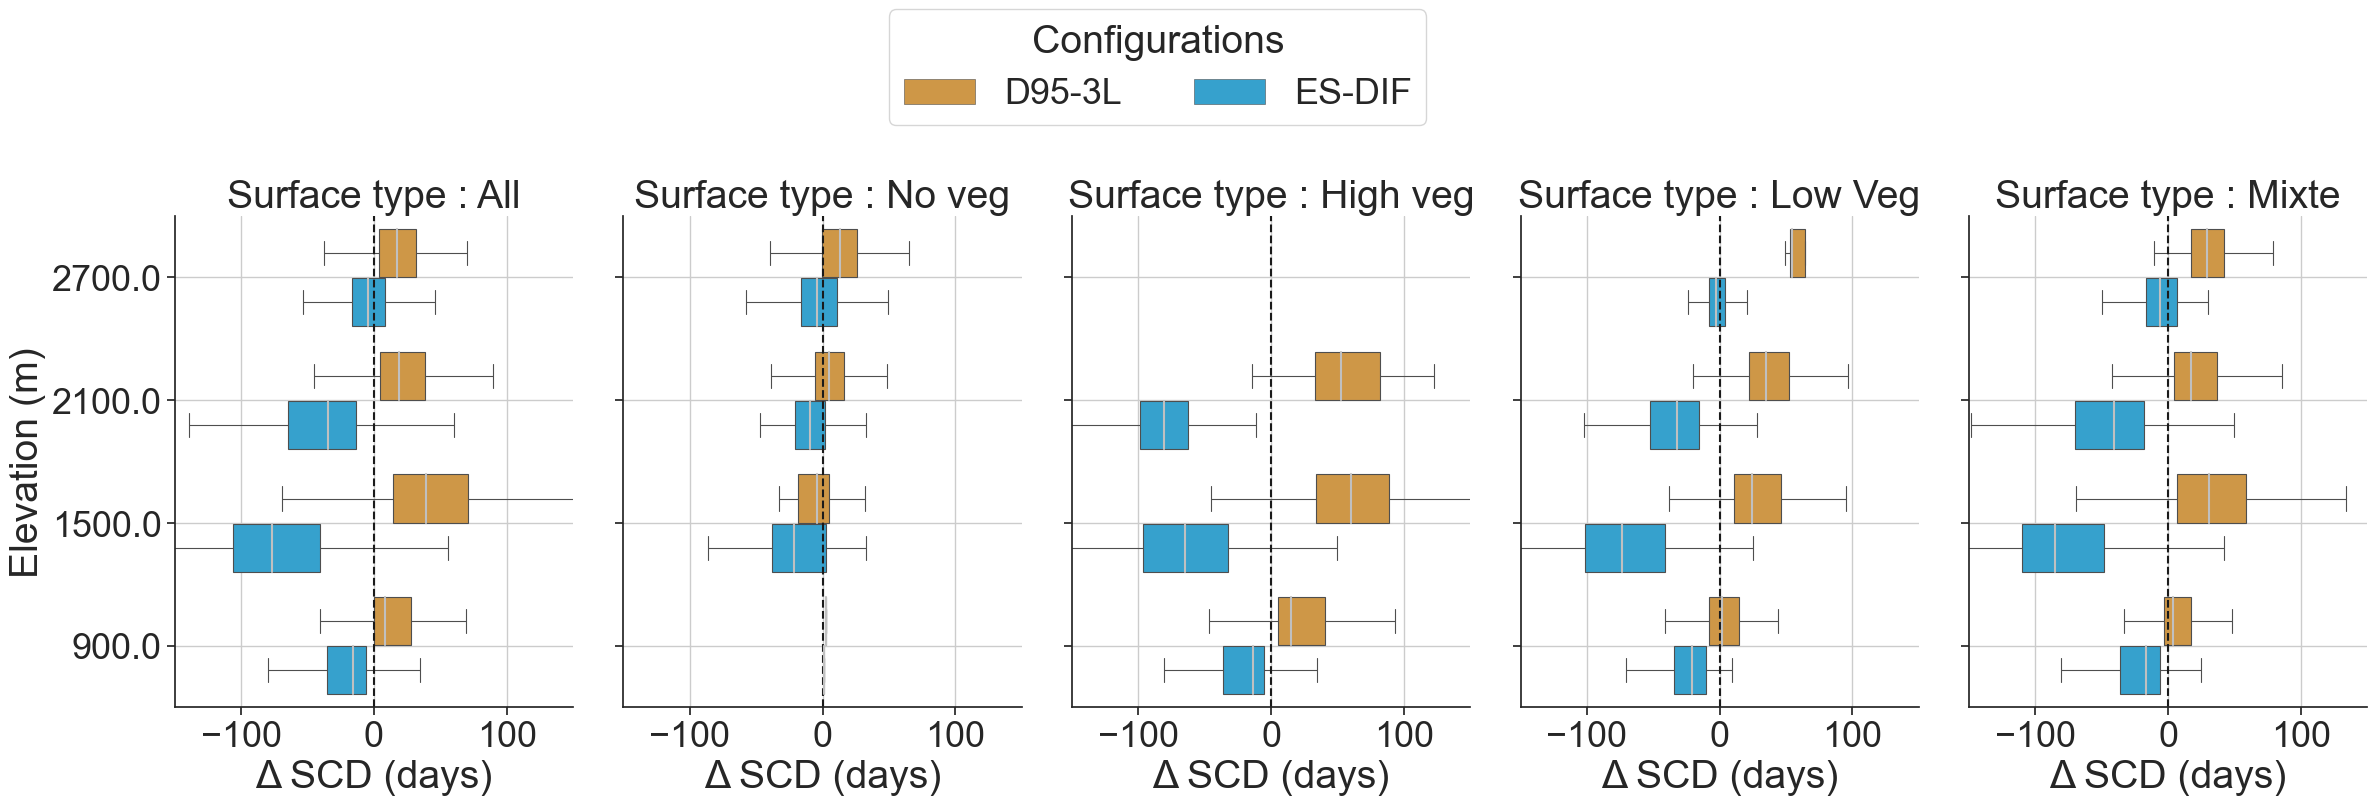

In [147]:
## Boxplot

form = 'article'

if form == 'article':
    choosen_alt = [900,1500,2100,2700]
    df_i = df[df['middle_slices_ZS'].isin(choosen_alt)]
elif form == 'all':
    choosen_alt = [300,600,900,1200,1500,1800,2100,2400,2700,3000]
    df_i = df[df['middle_slices_ZS'].isin(choosen_alt)]

sns.set(font_scale = 2.35)
sns.set_style("ticks")

g = sns.catplot(data=df_i,x =var,y = 'middle_slices_ZS',hue = 'Dataset',orient = 'h',col = 'veg_type',order = reversed(np.unique(df_i['middle_slices_ZS'])), palette = ls_name_color, kind = 'box',facet_kws={'sharex': True,'legend_out':True},showfliers=False, medianprops=dict(color="silver", linewidth =1.5),n_boot = 10000,linewidth = 0.8, height = 7, aspect = 0.7)
sns.move_legend(g, "center right", bbox_to_anchor=(0.55, 1.1),ncol = 3,title="Configurations", frameon=True)
# title
# new_title = 'Configurations'
# g._legend.set_title(new_title)
g.set_titles("Surface type : {col_name}")

# replace labels
new_labels = list(ls_EXPE.values())
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)
    
# Labelled and grid
for ax in g.axes.flat:
    ax.grid(True, axis='both')
    ax.set_ylabel('Elevation (m)')
    ax.set_xlabel('Δ SCD (days)')
    ax.axvline(0, ls='--', color = 'k', lw = 1.5)
    ax.set_xlim(-150,150)
    ax.set_yticklabels(np.array(list(reversed(np.unique(df_i['middle_slices_ZS'])))).astype(int))

# plt.show()
# plt.savefig(output_path+'Boxplot_scd_bias_'+form+'_'+yr_start+'-'+yr_end+'.pdf', bbox_inches = 'tight')

# plt.savefig(output_path+'Boxplot_scd_bias_'+form+'_all_EXPE.pdf', bbox_inches = 'tight')

# Section 2 : Methods

## Vegetation type location and elevational repartition 

In [261]:
## Load dataset

soil_type = xr.load_dataset('/cnrm/cen/users/NO_SAVE/monteirod/EXPE_AROME/ES_DIFF_UP_PATCH/fx/ARO_ALP3_fraction_of_each_patch.nc')
oro = xr.load_dataset('/cnrm/cen/users/NO_SAVE/monteirod/EXPE_AROME/orog_aro_era5.nc').set_coords(['lat','lon'])
ds = xr.merge([soil_type,oro])
shp_path = '/cnrm/cen/users/NO_SAVE/monteirod/Shapefile/Alpine_Convention_Perimeter_2018_v2_4326/'
ds = u.applied_mask_from_shp(ds,shp_path,'lat','lon').mean(dim = 'region').dropna(dim = 'x', how ='all').dropna(dim = 'y', how ='all')

ds = ds.set_coords(['P1','P2','P3'])

# Create the dataframe for histogram

ls_alt = np.arange(-150,3900,300)

df = []
thesh_veg = 0.75
ls_veg = ['All','P1','P2','P3','mixte']
ls_veg_name = ['All','No veg','High veg','Low Veg','Mixed']

ds_alt = u.per_alt(ds,ls_alt)

for j in ls_veg:
    print(j)
    if j == 'All':
        i_data = ds_alt['ZS']
    elif j == 'mixte':
        i_data = ds_alt['ZS'].where((ds_alt['P1'] < thesh_veg)*(ds_alt['P2'] < thesh_veg)*(ds_alt['P3'] < thesh_veg))            
    else:
        i_data = ds_alt['ZS'].where(ds_alt[j] >= thesh_veg)


    df.append(i_data.to_dataframe().reset_index().drop(columns = ['x','y']).dropna())
df = pd.concat(df, keys = ls_veg_name)
df = df.reset_index().rename(columns = {'level_0':'veg_type'})

# Create the dataframe

thesh_veg = 0.75
ls_veg = ['mixte','P1','P2','P3']
ls_veg_name = ['Mixed','No veg','High veg','Low Veg']
ls_values = [-1,1,2,3]
for j in range(0,len(ls_veg)):
    
    if ls_veg[j] == 'mixte':
        
        ds[ls_veg_name[j]] = xr.where(((ds['P1'] < thesh_veg)*(ds['P2'] < thesh_veg)*(ds['P3'] < thesh_veg)), ls_values[j],0)
    
    else:
    
        ds[ls_veg_name[j]] = xr.where((ds[ls_veg[j]] >= thesh_veg), ls_values[j],0)
        
ds = u.applied_mask_from_shp(ds,shp_path,'lat','lon').mean(dim = 'region').dropna(dim = 'x', how ='all').dropna(dim = 'y', how ='all')
ds['all'] = ds['No veg'] + ds['High veg'] + ds['Low Veg'] + ds['Mixed']

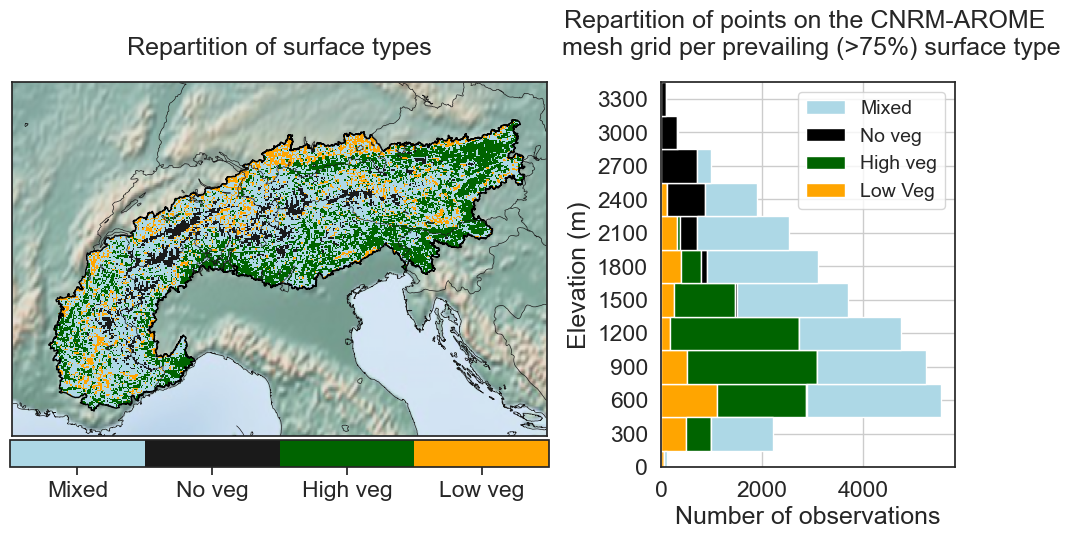

In [308]:
import matplotlib as mpl

cmap = mpl.colors.ListedColormap(['lightblue','k','darkgreen','orange'])
norm = mpl.colors.BoundaryNorm([-1,1,2,3,4], cmap.N)  

## Histogram of the repartition of obs per veg type and  SCD MODIS map over two years

fig = plt.figure(figsize = (12.5,5))
gs = plt.GridSpec(1, 2, width_ratios=[2,1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

sns.set(font_scale = 1.5)
sns.set_style("white")


m2 = Basemap(llcrnrlon=4,llcrnrlat=43,urcrnrlon=17.,urcrnrlat=49, epsg = 4326, lat_0 = 43.5, lon_0 = 5, resolution = 'h', ax = ax1)
m2.drawcountries(linewidth = 0.5)
m2.drawcoastlines(linewidth = 0.5)
m2.shadedrelief()
smap = m2.pcolormesh(ds.lon,ds.lat,ds['all'], cmap = cmap, norm = norm)

# Boundaries of the shapefile
shp.plot(ax=ax1,color='None', edgecolor='black', linewidth =1)

# Limits of the map and legend size
ax1.set( ylim = (43,49),xlim =(4,17), xticks = [], yticks = [])
ax1.set_title('Repartition of surface types', pad=20)
cbar = fig.colorbar(smap,ax=ax1, orientation = 'horizontal',ticks=[0,1.5,2.5,3.5], fraction = 0.07, pad = 0.01)
cbar.ax.set_xticklabels(['Mixed','No veg','High veg','Low veg'])


####################

### Histogram
histo = df[df['veg_type'] != 'All']
histo['middle_slices_ZS'] = histo['middle_slices_ZS'] - 150
g = sns.histplot(histo, y = "middle_slices_ZS", hue = 'veg_type',hue_order =['Mixed','No veg','High veg','Low Veg'],multiple = 'stack',binwidth=300, palette = ['lightblue','black','darkgreen','orange'], alpha = 1, ax = ax2)
sns.move_legend(g,loc = 'best',prop={'size': 14},ncol = 1,title=None, frameon=True)
ax2.set_xlabel('Number of observations')
ax2.set_ylabel('Elevation (m)')
ax2.grid(True)
ax2.set_ylim(0,3450)
ax2.set_title('Repartition of points on the CNRM-AROME \n mesh grid per prevailing (>75%) surface type', pad=20)
g.set(yticks = np.arange(0,3600,300));

plt.savefig(output_path+'Map_hist_Repartition_veg_type.png', bbox_inches = 'tight',dpi = 300)

## Illustration of the setup : Downscaling ERA5 - CNRM-AROME

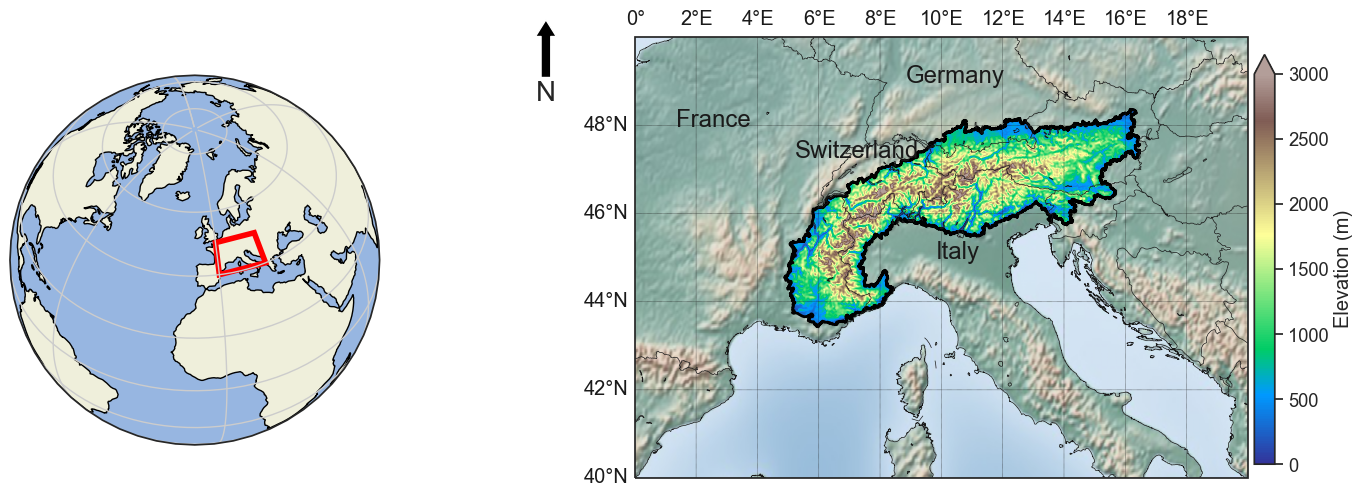

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from shapely.geometry.polygon import LinearRing
import matplotlib.patches as mpatches
import cmasher as cmr


extent = [-0, 20, 40, 50]
lonmin, lonmax, latmin, latmax = extent

sns.set(font_scale = 1.2)
sns.set_style("white")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(-10, 45))
ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines()

# inset location relative to main plot (ax) in normalized units
inset_x = 1
inset_y = 1
inset_size = 0.2

ax2 = plt.axes([1.2, 0, 1, 1], projection=ccrs.PlateCarree())

m2 = Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,urcrnrlon=lonmax,urcrnrlat=latmax, epsg = 4326, lat_0 = 43.5, lon_0 = 5, resolution = 'h', ax = ax2)
m2.drawparallels(np.arange(40,50,2),labels=[True,False,False,False], linewidth = 0.4)
m2.drawmeridians(np.arange(0,20,2),labels=[False,True,True,False], linewidth = 0.4)
m2.drawcountries(linewidth = 0.5)
m2.drawcoastlines(linewidth = 0.5)
m2.shadedrelief()

## Add rectangle to globe map

ax.add_patch(mpatches.Rectangle(xy=[lonmin, latmin], width=lonmax-lonmin, height=latmax-latmin,
                                facecolor='none', edgecolor='red',lw = 4,
                                transform=ccrs.PlateCarree()))
## Add DEM & Shapefile Alpconv

shp_path = '/cnrm/cen/users/NO_SAVE/monteirod/Shapefile/Alpine_Convention_Perimeter_2018_v2_4326/'
shp = geopandas.read_file(shp_path)
MNT = u.applied_mask_from_shp(xr.load_dataset('/cnrm/cen/users/NO_SAVE/monteirod/EXPE_AROME/orog_aro_era5.nc').set_coords(['lat','lon']),shp_path, 'lat','lon').mean(dim = 'region')

terrain_mod = cmr.get_sub_cmap('terrain', 0., 0.85)

# North arrow
x, y, arrow_length = 1.45, 1.15, 0.2
plt.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=7, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

# Annotate with surrounding contries
ax2.annotate('France',(4.5,48),xycoords='data',
            xytext=(-70, -1), textcoords='offset points', color ='k' ,arrowprops=None, fontsize = 'large')

ax2.annotate('Switzerland',(8.4,47.3),xycoords='data',
            xytext=(-70, -1), textcoords='offset points', color ='k' ,arrowprops=None, fontsize = 'large')

ax2.annotate('Germany',(12,49),xycoords='data',
            xytext=(-70, -1), textcoords='offset points', color ='k' ,arrowprops=None, fontsize = 'large')

ax2.annotate('Italy',(13,45),xycoords='data',
            xytext=(-70, -1), textcoords='offset points', color ='k' ,arrowprops=None, fontsize = 'large')


# Plot the DEM
im = m2.pcolor(MNT.lon,MNT.lat,MNT.ZS, cmap = terrain_mod, vmin = 0, vmax = 3000)
shp.plot(ax=ax2,color='None', edgecolor='black', linewidth =2)
fig.colorbar(im,ax = ax2, label = 'Elevation (m)', fraction = 0.032,pad=0.01, extend = 'max')

# plt.title('Study domain', fontsize = 'xx-large', psad = 50)
plt.savefig(output_path+'Config_and_Study_area.png', dpi = 300, bbox_inches = 'tight')

# Appendix A: Sensitivity of the snow cover fraction parameterization over vegetation

In [5]:
## Loading of sncv, snd needed before

for i in list(ls_EXPE.keys()):

    ds[i] = u.applied_mask_from_shp(ds[i].load(),shp_path,'lat','lon').mean(dim = 'region')
        

## Select only winter month and timestep where snd > 10 cm        
var = 'z0'

ds_used = {}

ls_month = [11,12,1,2,3,4] # Selected months
ls_month_name = ['J','F','M','A','M','J','J','A','S','O','N','D']

for i in list(ls_EXPE.keys()):
    ds_used[i] = ds[i].isel(time=ds[i].time.dt.month.isin(ls_month))

    if i == 'D95_3L' or i == 'ES_DIFF':
        wsn = 5
    else :
        wsn = 1    
    ds_used[i]['z0'] = (ds_used[i]['snd']/wsn)*(1/ds_used[i]['sncv'] -1)
    
for i in list(ls_EXPE.keys()):

    ds_used[i] = ds_used[i].where((ds_used[i]['snd'] > 0.1))


## Typical roughness length by veg_type 

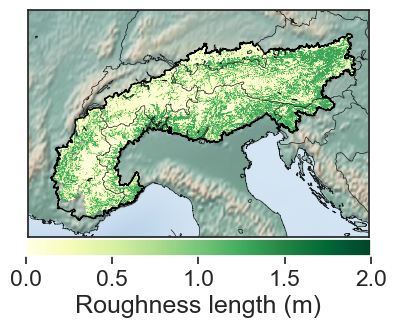

In [25]:
## Panel map 

var = 'z0'

yr_start = '2018'
yr_end = '2020'

sns.set_style("white")

fig, ax = plt.subplots(1,1,figsize = (6,3.2), sharex = True, sharey = True)
plt.subplots_adjust(wspace=0.015, hspace=0.0)
    
sns.set(font_scale = 1.5)

for i, ax in enumerate(fig.axes):
    if i < 7:
    # Map background
        m2 = Basemap(llcrnrlon=4,llcrnrlat=43,urcrnrlon=17.,urcrnrlat=49, epsg = 4326, lat_0 = 43.5, lon_0 = 5, resolution = 'h', ax = ax)
        m2.drawcountries(linewidth = 0.5)
        m2.drawcoastlines(linewidth = 0.5)
        m2.shadedrelief()

        smap = m2.pcolor(ds_used[list(ds_used.keys())[i]].lon,ds_used[list(ds_used.keys())[i]].lat,ds_used[list(ds_used.keys())[i]][var].sel(time = slice(yr_start,yr_end)).mean(dim = 'time').squeeze(),vmin = 0,vmax = 2,cmap = 'YlGn')    

        # Boundaries of the shapefile
        shp.plot(ax=ax,color='None', edgecolor='black', linewidth =1)

        # Limits of the map and legend size
        ax.set( ylim = (43,49),xlim =(4,17), xticks = [], yticks = [])

            
fig.colorbar(smap,ax = list(fig.axes), orientation = 'horizontal', label = ('Roughness length (m)'), fraction = 0.07, pad = 0.01)

plt.savefig(output_path+'Panel_'+var+'_'+yr_start+'-'+yr_end+'_one.png', bbox_inches = 'tight', dpi = 300)

In [26]:
### Prepare boxplot 

var = 'z0'
ds_shaped = {}

for i in list(ls_EXPE.keys()):
    print(i)
    ds_shaped[i] = ds_used[i].sel(time = slice(yr_start,yr_end)).mean(dim = 'time')
    
# Create the dataframe
df = []
thesh_veg = 0.75
ls_veg = ['All','P1','P2','P3','mixte']
ls_veg_name = ['All','No veg','High veg','Low Veg','Mixte']

for j in ls_veg:
    print(j)
    df_j = []
    for i in range(0,len(list(ds_shaped.values()))):
        if j == 'All':
            i_data = ds_shaped[list(ds_shaped.keys())[i]][var]
        elif j == 'mixte':
            i_data = ds_shaped[list(ds_shaped.keys())[i]][var].where((soil_type['P1'] < thesh_veg)*(soil_type['P2'] < thesh_veg)*(soil_type['P3'] < thesh_veg))            
        else:
            i_data = ds_shaped[list(ds_shaped.keys())[i]][var].where(soil_type[j] >= thesh_veg)
    
        df_i = i_data.to_dataframe().reset_index().drop(columns = ['x','y']+['ZS']).dropna()
        df_j.append(df_i)
    df_j = pd.concat(df_j, keys = list(ds_shaped.keys()))
    df.append(df_j.reset_index().rename(columns = {'level_0':'Dataset'}))

df = pd.concat(df, keys = ls_veg_name).drop(columns = 'level_1')
df = df.reset_index().rename(columns = {'level_0':'veg_type'})

D95_3L
ES_DIFF
All
P1
P2
P3
mixte


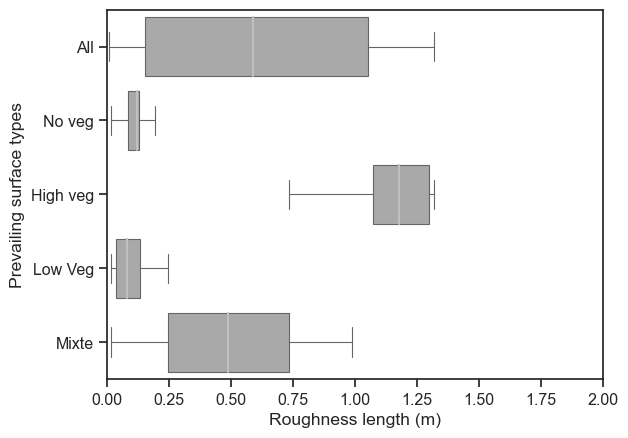

In [31]:
sns.set(font_scale = 1.05)
sns.set_style("ticks")

df_i = df[df['Dataset'] == 'D95_3L']

g = sns.boxplot(data=df_i,x =var,y = 'veg_type',orient = 'h', color = 'darkgrey',showfliers=False, medianprops=dict(color="silver", linewidth =1.5),linewidth = 0.8)
# sns.move_legend(g, "center right", bbox_to_anchor=(0.75, 1.15),ncol = 1,title="Configurations", frameon=True)
plt.ylabel('Prevailing surface types')
plt.xlabel('Roughness length (m)')
plt.xlim(0,2)

plt.savefig(output_path+'Boxplot_'+var+'_one.pdf', bbox_inches = 'tight')

## Snow fraction parameterization curves

In [77]:
def fsc(hs,wsn,z0):
    f = hs/(hs+wsn*z0)
    return f

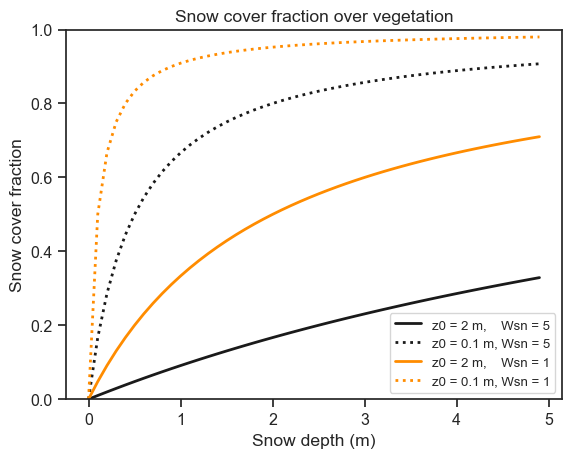

In [78]:
ls_hs = np.arange(0,5,0.1)


## High veg (z0 = 1m), high par (wsn = 5)
x = []
for i in ls_hs:
    x.append(fsc(i,5,2))

plt.plot(ls_hs,x, color = 'k', ls = '-',lw= 2, label = 'z0 = 2 m,    Wsn = 5')

## Low veg (z0 = 0.1m), high par (wsn = 5)
x = []
for i in ls_hs:
    x.append(fsc(i,5,0.1))

plt.plot(ls_hs,x, color = 'k', ls = ':',lw= 2, label = 'z0 = 0.1 m, Wsn = 5')

## High veg (z0 = 1m), high par (wsn = 1)
x = []
for i in ls_hs:
    x.append(fsc(i,1,2))

plt.plot(ls_hs,x, color = 'darkorange', ls = '-',lw= 2, label = 'z0 = 2 m,    Wsn = 1')

## High veg (z0 = 0.1m), high par (wsn = 5)
x = []
for i in ls_hs:
    x.append(fsc(i,1,0.1))

plt.plot(ls_hs,x, color = 'darkorange', ls = ':',lw= 2,  label = 'z0 = 0.1 m, Wsn = 1')
plt.legend(loc = 'lower right', prop={'size': 9.5})
plt.ylim(0,1)

plt.xlabel('Snow depth (m)')
plt.ylabel('Snow cover fraction')
plt.title('Snow cover fraction over vegetation')

plt.savefig(output_path+'Snow_cover_fraction_over_veg_parameter_sensitivity.pdf', bbox_inches = 'tight')

# Appendix B: Impact of the initialization (spin-up) approach on snowpack simulations

In [153]:
## Load data

shp_path = '/cnrm/cen/users/NO_SAVE/monteirod/Shapefile/Alpine_Convention_Perimeter_2018_v2_4326/'
shp = geopandas.read_file(shp_path)

data_path = '/cnrm/cen/users/NO_SAVE/monteirod/EXPE_AROME/'
output_path = '/home/monteirod/tmp/EXPE_AROME/Article_AROME/'

ls_EXPE = {'ES_DIFF_sg_LSOC_PATCH':'ES-DIF-OPT','ES_DIFF_OPT_spin_up':'ES-DIF-OPT_spin-up'}

ls_name_color = {'MODIS':'gray','CSNOW':'gray','OBS':'black','D95_3L':"#e49b30",'ES_DIFF':"#1dabe6",'ES_DIFF_UP_PATCH':'#79c08a','ES_DIFF_UP_PATCH_GFLUX':'#ab50d8','ES_DIFF_UP_PATCH_GFLUX_WSN1':'#865e52','ES_DIFF_sg_LSOC_PATCH':'#006c00','ES_DIFF_OPT_RIL':'darkgrey'}

years = ['2018','2019','2020']

var = { 'ts': 'Surface temperature',
 'snd': 'Snow depth',
 'swe': 'Snow water equivalent',
 'snct': 'Snow cover fraction',
 'atot': 'Total albedo',
 'tas': 'Temperature at 2m',
 'pr' : 'Precipitation',
 'ts': 'Surface temperature',
 'tp2': 'Soil temperature 5cm',
 'tp3': 'Soil temperature 10cm',
 'dswe': 'SWE variation',
 'snmlt': 'Snowmelt',
 'hfgr': 'Ground heat flux \n (surface energy balance)',
 'hfle': 'Latent heat flux',
 'hfsc': 'Sensible heat flux',
 'rtot': 'Net radiation \n (radiative balance)',
 'lwdn': 'Downward longwave',
 'swdn': 'Downward shortwave',
 'lwun': 'Upward longwave',
 'swun': 'Upward shortwave',
 'z0s': 'Roughness length surface',
 'z0hs': 'Roughness length surface H ?',
 'cchs': 'Drag thermal coef',
 'ccds': 'Drag momentum coef',
 'mrso':'Total soil water content',
 'tp10': 'Soil temperature at 2m',
 'tp14': 'Soil temperature at 12m'
    }


In [154]:
## Load dataset

# ls_var = list(var.keys())
ls_var = ['snd', 'mrso','tp10']

ds = {}

oro = xr.load_dataset('/cnrm/cen/users/NO_SAVE/monteirod/EXPE_AROME/orog_aro_era5.nc').set_coords(['lat','lon'])
soil_type = xr.load_dataset('/cnrm/cen/users/NO_SAVE/monteirod/EXPE_AROME/ES_DIFF_UP_PATCH/fx/ARO_ALP3_fraction_of_each_patch.nc')
import time 

for i in list(ls_EXPE.keys()):
    print(i)
        
    start = time.time()

    ds[i] = xr.merge([xr.open_mfdataset(data_path+i+'/day/'+j+'_*.nc', chunks = 'auto', combine = 'nested',concat_dim='time', coords = 'minimal', data_vars='minimal')[j].sel(time = slice('01-01-'+years[0],'12-31-'+years[-1])).chunk(chunks={'y': 35, 'x': 35, 'time': -1}) for j in ls_var]+[oro]+[soil_type], join = 'override', compat = 'override').set_coords('ZS')

    end = time.time()
    print(end - start)


ES_DIFF_sg_LSOC_PATCH
32.53466320037842
ES_DIFF_OPT_spin_up
44.93950271606445


In [155]:
for i in list(ls_EXPE.keys()):
    print(i)
        
    start = time.time()

    ds[i].load()
    ds[i]['tp10'] = ds[i]['tp10'] - 273.15
    end = time.time()
    print(end - start)


ES_DIFF_sg_LSOC_PATCH
66.27057409286499
ES_DIFF_OPT_spin_up
85.73033094406128


## Difference of the initialization fields

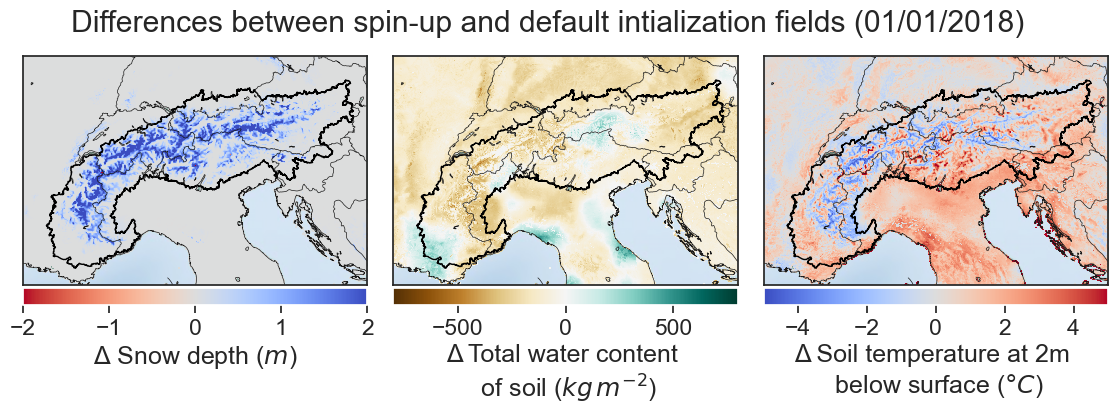

In [26]:
## Panel map 

timestep = '2018-01-01'
ls_var = ['snd', 'mrso','tp10']
ls_var_name = ['Snow depth ($m$)', 'Total water content \n of soil ($kg\,m^{-2}$)','Soil temperature at 2m \n below surface ($°C$)']
ls_vmax = [2,800,5]
ls_cmap = ['coolwarm_r','BrBG','coolwarm']

sns.set_style("white")

fig, ax = plt.subplots(1,3,figsize = (14,4.2), sharex = True, sharey = True)
plt.subplots_adjust(wspace=0.075, hspace=0.0)
    
sns.set(font_scale = 1.5)

for i, ax in enumerate(fig.axes):
    if i < 7:
    # Map background
        m2 = Basemap(llcrnrlon=4,llcrnrlat=43,urcrnrlon=17.,urcrnrlat=49, epsg = 4326, lat_0 = 43.5, lon_0 = 5, resolution = 'h', ax = ax)
        m2.shadedrelief()
        m2.drawcountries(linewidth = 0.5)
        m2.drawcoastlines(linewidth = 0.5)
        
        diff = (ds['ES_DIFF_OPT_spin_up'][ls_var[i]] - ds['ES_DIFF_sg_LSOC_PATCH'][ls_var[i]]).sel(time = timestep).mean(dim = 'time')
        
        if ls_var[i] == 'snd':
            smap = m2.pcolor(ds['ES_DIFF_OPT_spin_up'].lon,ds['ES_DIFF_OPT_spin_up'].lat,diff,vmin = -ls_vmax[i],vmax = ls_vmax[i],cmap = ls_cmap[i], label = ls_var_name[i])    
        else:
            smap = m2.pcolor(ds['ES_DIFF_OPT_spin_up'].lon,ds['ES_DIFF_OPT_spin_up'].lat,diff.where(diff !=0),vmin = -ls_vmax[i],vmax = ls_vmax[i],cmap = ls_cmap[i], label = ls_var_name[i])    

        # Boundaries of the shapefile
        shp.plot(ax=ax,color='None', edgecolor='black', linewidth =1)

        # Limits of the map and legend size
        ax.set(ylim = (43,49), xlim =(4,17), xticks = [], yticks = [])
        # ax.legend(prop={'size': 14}, handlelength=0, loc = 'upper left',fontsize = 100, framealpha=0.8)
          
        fig.colorbar(smap,ax = ax, orientation = 'horizontal', label = ('Δ '+ls_var_name[i]), fraction = 0.1, pad = 0.01)

fig.suptitle('Differences between spin-up and default intialization fields (01/01/2018)', y=0.85)

plt.savefig(output_path+'Panel_differences_init_fields.png', bbox_inches = 'tight', dpi = 300)

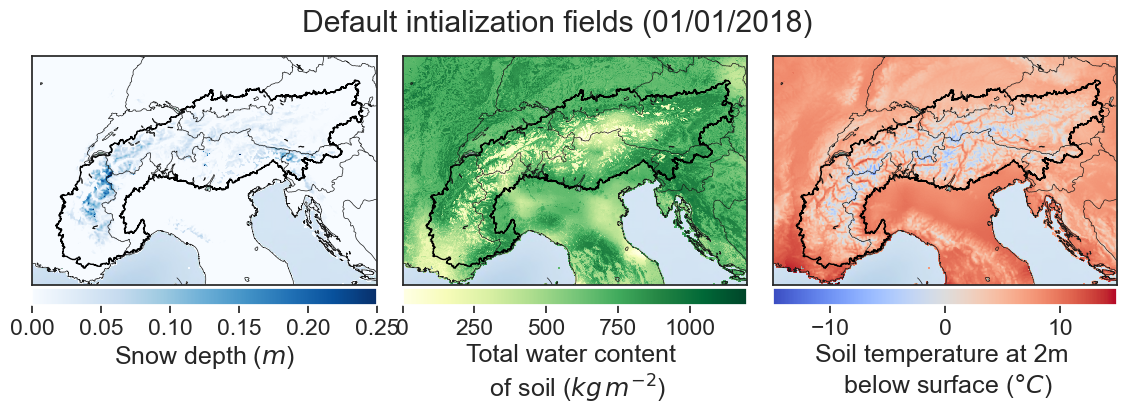

In [27]:
## Panel map 

timestep = '2018-01-01'
ls_var = ['snd', 'mrso','tp10']
ls_var_name = ['Snow depth ($m$)', 'Total water content \n of soil ($kg\,m^{-2}$)','Soil temperature at 2m \n below surface ($°C$)']
ls_vmin = [0,0,-15]
ls_vmax = [0.25,1200,15]
ls_cmap = ['Blues','YlGn','coolwarm']

sns.set_style("white")

fig, ax = plt.subplots(1,3,figsize = (14,4.2), sharex = True, sharey = True)
plt.subplots_adjust(wspace=0.075, hspace=0.0)
    
sns.set(font_scale = 1.5)

for i, ax in enumerate(fig.axes):
    if i < 7:
    # Map background
        m2 = Basemap(llcrnrlon=4,llcrnrlat=43,urcrnrlon=17.,urcrnrlat=49, epsg = 4326, lat_0 = 43.5, lon_0 = 5, resolution = 'h', ax = ax)
        m2.shadedrelief()
        m2.drawcountries(linewidth = 0.5)
        m2.drawcoastlines(linewidth = 0.5)
        
        diff = ds['ES_DIFF_sg_LSOC_PATCH'][ls_var[i]].sel(time = timestep).mean(dim = 'time')
        smap = m2.pcolor(ds['ES_DIFF_OPT_spin_up'].lon,ds['ES_DIFF_OPT_spin_up'].lat,diff.where(diff < 10e10),vmin = ls_vmin[i],vmax = ls_vmax[i],cmap = ls_cmap[i], label = ls_var_name[i])    

        # Boundaries of the shapefile
        shp.plot(ax=ax,color='None', edgecolor='black', linewidth =1)

        # Limits of the map and legend size
        ax.set(ylim = (43,49), xlim =(4,17), xticks = [], yticks = [])
        # ax.legend(prop={'size': 14}, handlelength=0, loc = 'upper left',fontsize = 100, framealpha=0.8)
          
        fig.colorbar(smap,ax = ax, orientation = 'horizontal', label = (ls_var_name[i]), fraction = 0.1, pad = 0.01)

fig.suptitle('Default intialization fields (01/01/2018)', y=0.85)

plt.savefig(output_path+'Panel_default_init_fields.png', bbox_inches = 'tight', dpi = 300)

## Spin up impact at specific sites

In [156]:
## Load data

obs_snd = xr.load_dataset('/cnrm/cen/users/NO_SAVE/monteirod/Reference_Dataset/SND_OBS/Extensive_OBS/Extensive_stations_obs_2018-2020.nc')

## Duplicate Tor to get a second with new coords (closer to AROME grid points)
Tor2 = obs_snd.sel(Station_Name = 'IT-Tor')
Tor2['lat'] = 45.86566556
Tor2['lon'] = 7.57610378
Tor2['Station_Name'] = 'IT-Torh'
obs_snd = xr.concat([obs_snd,Tor2], dim = 'Station_Name')
##

obs_snd['swun'] = obs_snd['swun'].where(obs_snd['swun'] >= 0)
obs_snd['lwun'] = obs_snd['lwun'].where(obs_snd['lwun'] >= 0)
obs_snd['tp2'] = obs_snd['tp2'].where(obs_snd['tp2'] + 273.15 >= 0)
obs_snd['tas'] = obs_snd['tas'].where(obs_snd['tas'] + 273.15 >= 0)


# Replacing IT-Lsn snd values of Nan by 0
# obs_snd['snd'][2,:] = [0]*len(obs_snd['snd'][2,:])

# Replace Torgnon name
ls_station = {'Davos_meteoswiss': 'Davos','IT-Tor':'Torgnon','Weissfluhjoch':'Weissfluhjoch','CLB': 'Col du Lac Blanc'}
ls_station_abbrv = {'Davos_meteoswiss': 'Davos','IT-Tor':'Torgnon','Weissfluhjoch':'Weiss','CLB': 'CLB'}
obs_snd = obs_snd.sel(Station_Name = list(ls_station.keys()))
obs_snd['Station_Name'] = list(ls_station.keys())
ls_lon = obs_snd.lon
ls_lat = obs_snd.lat


In [157]:
incr_lat = 2.5/(40000/360)
def incr_lon(lat):
    return 2.5/((40000/360)*np.cos(np.deg2rad(lat)))

oro_aro = xr.load_dataset('/cnrm/cen/users/NO_SAVE/monteirod/EXPE_AROME/orog_aro_era5.nc').set_coords(['lat','lon'])

ls_y,ls_x = [], []
test = []

## Get the list of x, y index corresponding AROME dimension (here, we remove 2 points possibility)
for j in range(0,len(list(ls_station.keys()))):
    
    i_index = oro_aro.ZS.where((oro_aro.lon > ls_lon[j] - incr_lon(ls_lat[j])/2)*(oro_aro.lon < ls_lon[j] + incr_lon(ls_lat[j])/2)*(oro_aro.lat > ls_lat[j] -incr_lat/2)*(oro_aro.lat < ls_lat[j] + incr_lat/2))
    test.append(i_index)
    if np.shape((np.where(~np.isnan(i_index)))) == (2,1):
        ls_y.append(int(np.where(~np.isnan(i_index))[0]))
        ls_x.append(int(np.where(~np.isnan(i_index))[1]))
        
## Make the selection over initial ds at obs points
ds_point = {}

for j in list(ls_EXPE.keys()):
    print(j)
    ds_point[j] = ds[j].isel(x = xr.DataArray(ls_x, dims = 'Station_Name'),y = xr.DataArray(ls_y, dims = 'Station_Name'))
    ds_point[j]['Station_Name'] = list(ls_station.keys())



ES_DIFF_sg_LSOC_PATCH
ES_DIFF_OPT_spin_up


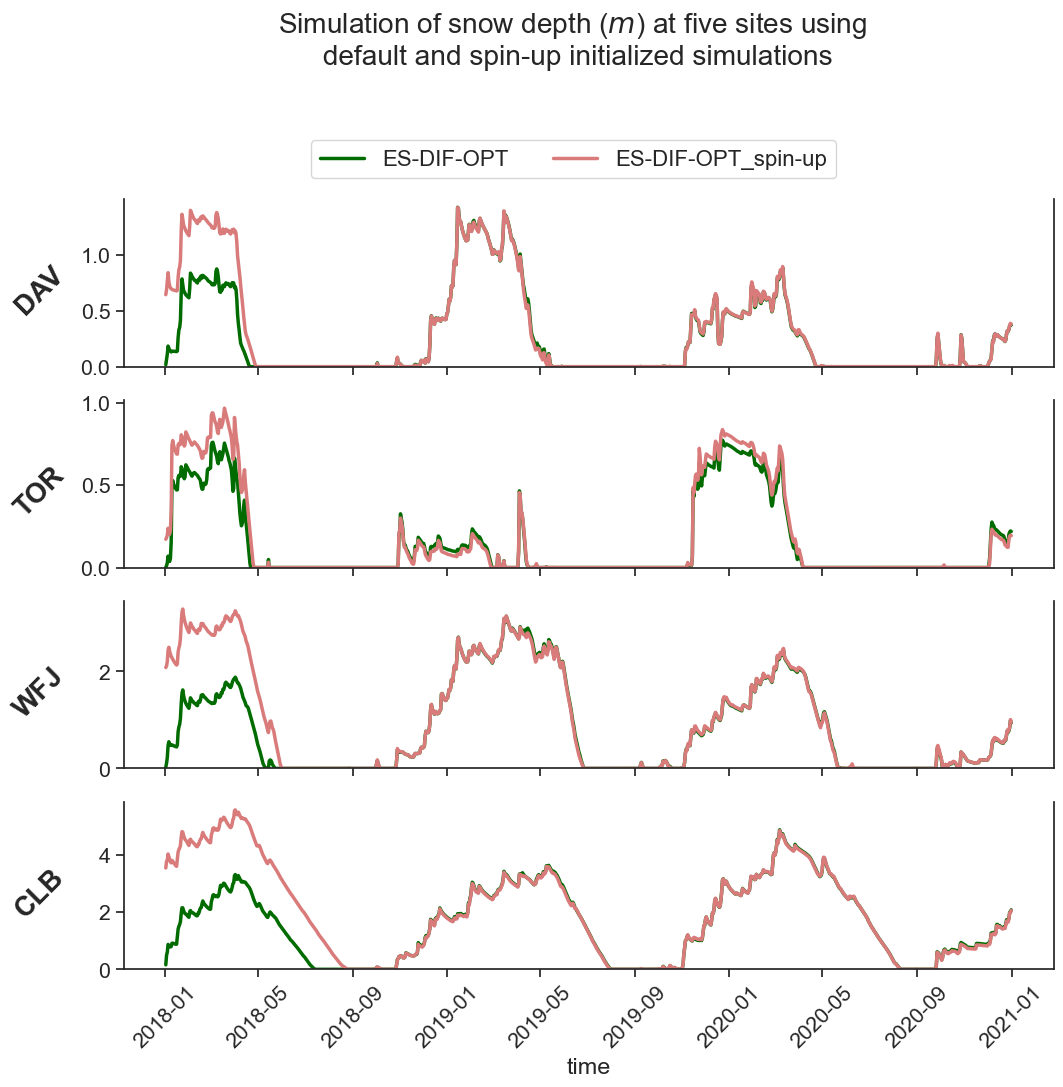

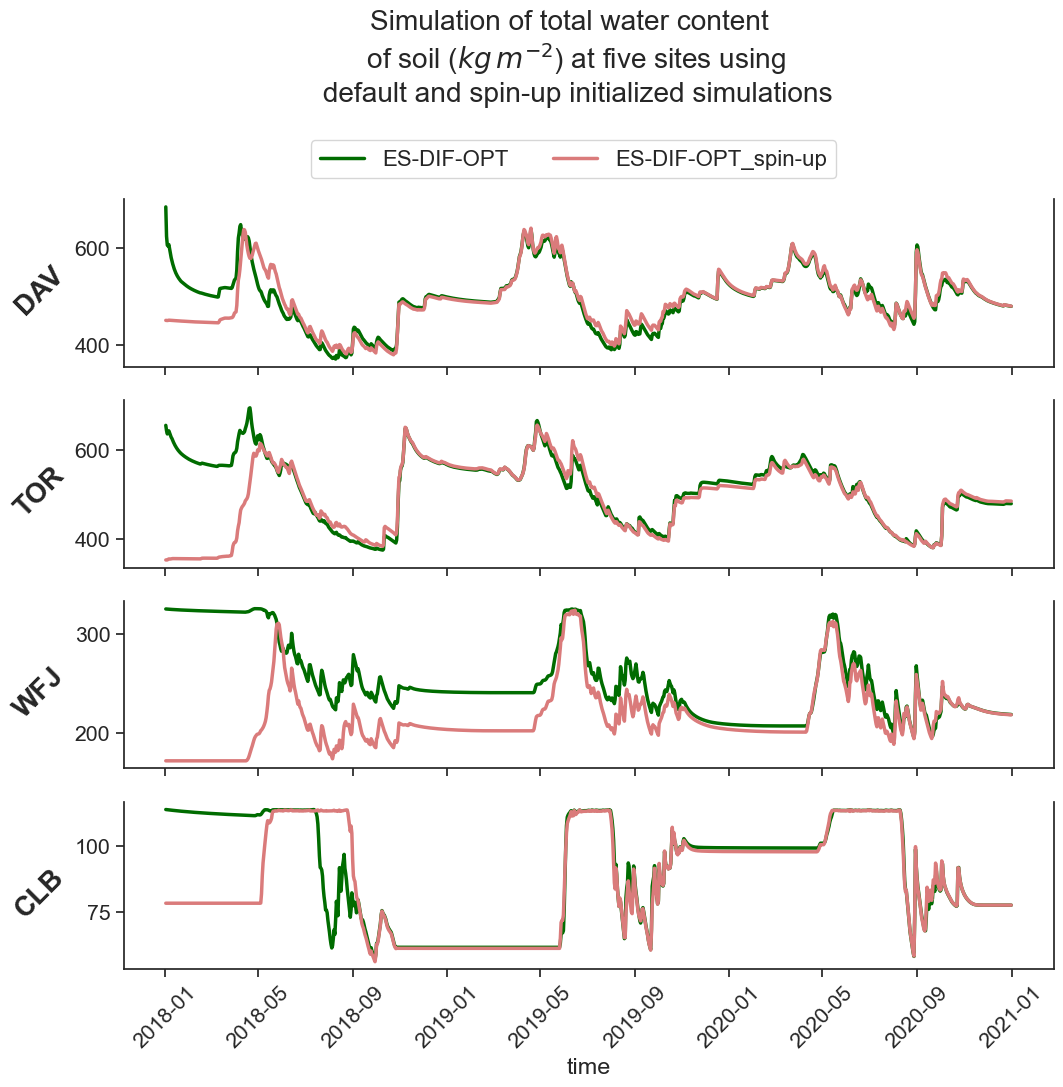

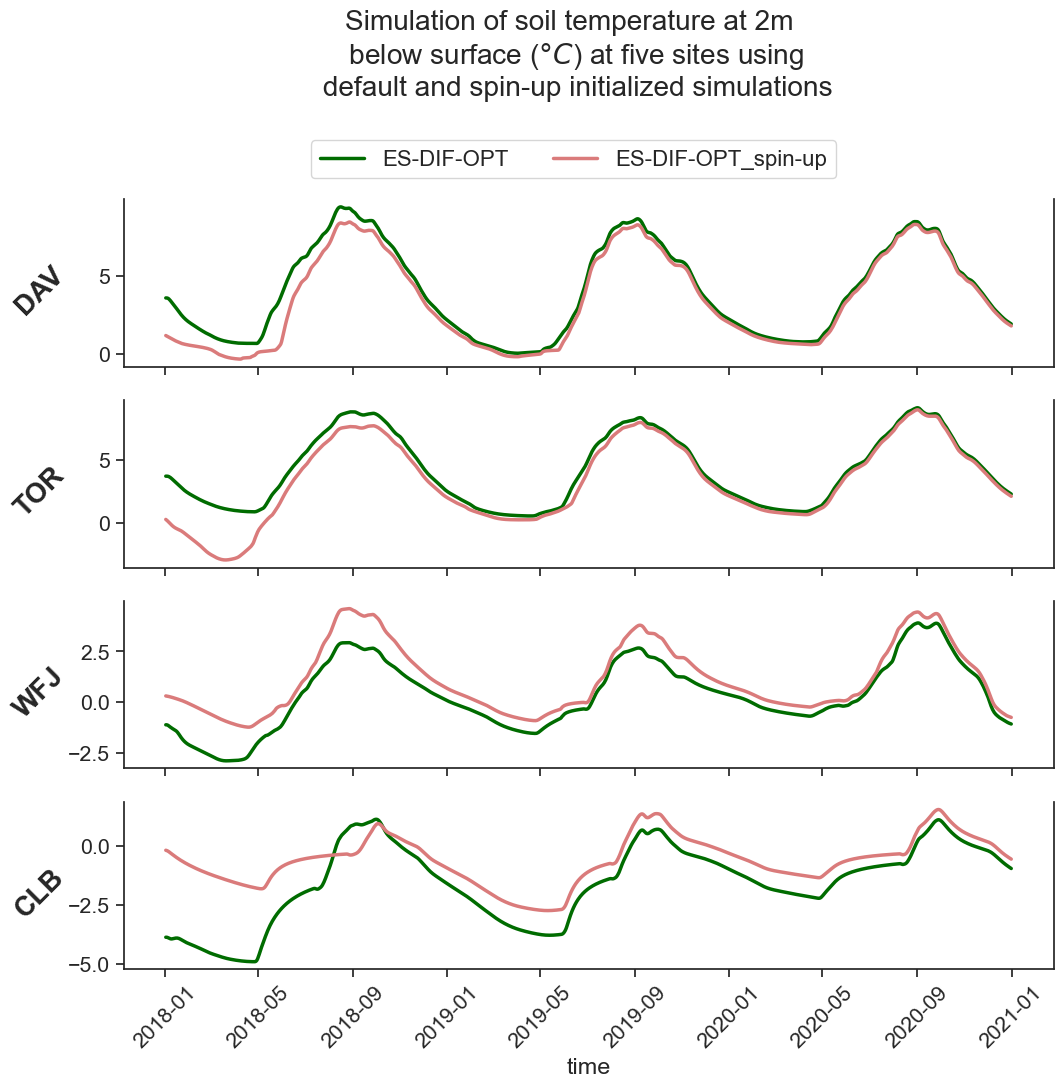

In [158]:
import matplotlib.patches as mpatches
import numpy.ma as ma
ls_station_abbrv = {'Davos_meteoswiss': 'DAV','IT-Tor':'TOR','Weissfluhjoch':'WFJ','CLB': 'CLB'}

sns.set(font_scale = 1.2)
sns.set_style("ticks")

var_name = {'snd':'snow depth ($m$)','mrso':'total water content \n of soil ($kg\,m^{-2}$)','tp10':'soil temperature at 2m \n below surface ($°C$)'}
var = ['snd','mrso','tp10']

for j in range(0,len(var)):
    fig, ax = plt.subplots(len(list(ls_station.keys())),1, figsize = (10,8), sharex = True)
    for i in range(0,len(list(ls_station.keys()))):
    
        
        for k in ls_EXPE:
            ls_name_color = {'MODIS':'gray','CSNOW':'gray','OBS':'black','D95_3L':"#e49b30",'ES_DIFF':"#1dabe6",'ES_DIFF_UP_PATCH':'#79c08a','ES_DIFF_UP_PATCH_GFLUX':'#ab50d8','ES_DIFF_UP_PATCH_GFLUX_WSN1':'#865e52','ES_DIFF_sg_LSOC_PATCH':'#006c00','ES_DIFF_OPT_spin_up':'#DA7B7B'}
            ax[i].plot(ds_point[k].time,ds_point[k][var[j]].sel(Station_Name = list(ls_station.keys())[i]), color = ls_name_color[k], lw = 2.5, label = ls_EXPE[k])
                    
        plt.xticks(rotation=70)
        ax[i].spines["top"].set_visible(False)

        for tick in ax[i].get_xticklabels():
            tick.set_rotation(45)

        if var[j] == 'snd':
            ax[i].set_ylim(0,None)

        handles, labels = ax[i].get_legend_handles_labels()

        ax[i].axvspan(np.datetime64('2018-01'), np.datetime64('2018-09'), color='grey', alpha=0.2, lw=0)
        ax[i].axvspan(np.datetime64('2020-09'), np.datetime64('2021-01'), color='grey', alpha=0.2, lw=0)
        # ax[i].set_xlim(ds_point['ES_DIFF_OPT_spin_up'].time[0],ds_point['ES_DIFF_OPT_spin_up'].time[-1])
        
        ax[i].set_ylabel(list(ls_station_abbrv.values())[i],rotation = 45, fontsize = 17,fontweight='bold')
        ax[i].yaxis.set_label_coords(-0.08,0.4)

        if i == len(list(ls_station.keys()))-1:
            ax[i].set_xlabel('time')
        
    fig.suptitle('Simulation of '+list(var_name.values())[j]+' at five sites using \n default and spin-up initialized simulations', y = 1.05)
    fig.legend(handles, labels, loc='upper center', ncol = 2,bbox_to_anchor=(0.5, 0.95), prop={'size': 16})

    plt.savefig(output_path+'Panel_time_series_'+var[j]+'_spin_up_extensive_stations.pdf', bbox_inches ='tight')

# Appendix D: Multivariate comparison at four well-instrumented sites + Discussion section 4.4

In [80]:
## Load data

obs_snd = xr.load_dataset('/cnrm/cen/users/NO_SAVE/monteirod/Reference_Dataset/SND_OBS/Extensive_OBS/Extensive_stations_obs_2018-2020.nc')

## Duplicate Tor to get a second with new coords (closer to AROME grid points)
Tor2 = obs_snd.sel(Station_Name = 'IT-Tor')
Tor2['lat'] = 45.86566556
Tor2['lon'] = 7.57610378
Tor2['Station_Name'] = 'IT-Torh'
obs_snd = xr.concat([obs_snd,Tor2], dim = 'Station_Name')

## Pre-treat the variables
obs_snd['swun'] = obs_snd['swun'].where(obs_snd['swun'] >= 0)
obs_snd['lwun'] = obs_snd['lwun'].where(obs_snd['lwun'] >= 0)
obs_snd['tp2'] = obs_snd['tp2'].where(obs_snd['tp2'] + 273.15 >= 0)
obs_snd['tas'] = obs_snd['tas'].where(obs_snd['tas'] + 273.15 >= 0)

# Replace Torgnon name
ls_station = {'Davos_meteoswiss': 'Davos','IT-Tor':'Torgnon','Weissfluhjoch':'Weissfluhjoch','CLB': 'Col du Lac Blanc'}
ls_station_abbrv = {'Davos_meteoswiss': 'DAV','IT-Tor':'TOR','Weissfluhjoch':'WFJ','CLB': 'CLB'}
obs_snd = obs_snd.sel(Station_Name = list(ls_station.keys()))
obs_snd['Station_Name'] = list(ls_station.keys())
ls_lon = obs_snd.lon
ls_lat = obs_snd.lat


## Create experiments datasets with only grid points at observation location (save as a netcdf)

In [21]:
incr_lat = 2.5/(40000/360)
def incr_lon(lat):
    return 2.5/((40000/360)*np.cos(np.deg2rad(lat)))

oro_aro = xr.load_dataset('/cnrm/cen/users/NO_SAVE/monteirod/EXPE_AROME/orog_aro_era5.nc').set_coords(['lat','lon'])

ls_y,ls_x = [], []
test = []

## Get the list of x, y index corresponding AROME dimension (here, we remove 2 points possibility)
for j in range(0,len(list(ls_station.keys()))):
    
    i_index = oro_aro.ZS.where((oro_aro.lon > ls_lon[j] - incr_lon(ls_lat[j])/2)*(oro_aro.lon < ls_lon[j] + incr_lon(ls_lat[j])/2)*(oro_aro.lat > ls_lat[j] -incr_lat/2)*(oro_aro.lat < ls_lat[j] + incr_lat/2))
    test.append(i_index)
    if np.shape((np.where(~np.isnan(i_index)))) == (2,1):
        ls_y.append(int(np.where(~np.isnan(i_index))[0]))
        ls_x.append(int(np.where(~np.isnan(i_index))[1]))
        
## Make the selection over initial ds at obs points
ds_point = {}

for j in list(ls_EXPE.keys()):
    print(j)
    ds_point[j] = ds[j].isel(x = xr.DataArray(ls_x, dims = 'Station_Name'),y = xr.DataArray(ls_y, dims = 'Station_Name'))
    ds_point[j]['Station_Name'] = list(ls_station.keys())

for j in list(ls_EXPE.keys()):
    print(j)
    ds_point[j] = ds_point[j].where(np.abs(ds_point[j].ZS - obs_snd.ZS) < 200, drop = True)
    
obs_snd = obs_snd.sel(Station_Name = ds_point[list(ds_point.keys())[0]].Station_Name)

for j in list(ls_EXPE.keys()):
    write_job = ds_point[j].to_netcdf("/cnrm/cen/users/NO_SAVE/monteirod/EXPE_AROME/"+j+'/'+j+'_ARO_obs_extensive_snow.nc', compute=False)
    # Write the job with a progress bar view
    with ProgressBar():
        print(j)
        write_job.compute()

ES_DIFF_OPT_RIL
ES_DIFF_OPT_RIL
ES_DIFF_OPT_RIL
[########################################] | 100% Completed | 392.05 s


## Load CNRM-AROME experiments at observation location## Load ARO at OBS loc

In [81]:
ds_point = {}
data_path = '/cnrm/cen/users/NO_SAVE/monteirod/EXPE_AROME/'

for j in list(ls_EXPE.keys()):
    ds_point[j] = xr.load_dataset(data_path+j+'/'+j+'_ARO_obs_extensive_snow.nc')
    # ds_point[j]['Station_Name'] = obs_snd.Station_Name
    ds_point[j]['pr'] = ds_point[j]['pr']*3600
    ds_point[j]['tas'] = ds_point[j]['tas'] - 273.15 
    ds_point[j]['tp2'] = ds_point[j]['tp2'] - 273.15 
    ds_point[j]['ts'] = ds_point[j]['ts'] - 273.15
    ds_point[j]['snd'] = ds_point[j]['snd']*100 

    if j != "D95_3L":
        ds_point[j]['tp3'] = ds_point[j]['tp3'] - 273.15 

obs_snd = obs_snd.sel(Station_Name = list(ls_station.keys()))

## Map with the DEM and the location of the well-instrumented stations

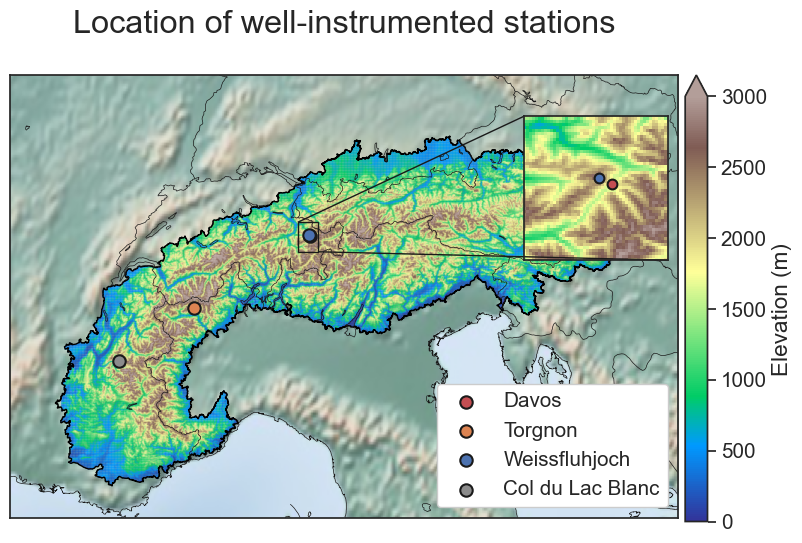

In [6]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
# Load DEM
MNT = u.applied_mask_from_shp(xr.load_dataset('/cnrm/cen/users/NO_SAVE/monteirod/Reference_Dataset/MNT_1km/SRTM_DEM_1km.nc'),shp_path, 'y','x').mean(dim = 'region')

# Plot the study domain background
sns.set(font_scale = 1.35)
sns.set_style('white')
terrain_mod = cmr.get_sub_cmap('terrain', 0., 0.85)

fig, ax = plt.subplots(figsize = (9,7))

m2 = Basemap(llcrnrlon=4,llcrnrlat=43,urcrnrlon=17.,urcrnrlat=49, epsg = 4326, lat_0 = 43.5, lon_0 = 5, resolution = 'h', ax = ax)
# m2.drawparallels(np.arange(40,50,2),labels=[True,False,False,False], linewidth = 0.4)
# m2.drawmeridians(np.arange(0,17,2),labels=[False,True,True,False], linewidth = 0.4)
m2.drawcountries(linewidth = 0.5)
m2.drawcoastlines(linewidth = 0.5)
m2.shadedrelief()

# Plot the DEM
im = m2.pcolor(MNT.x,MNT.y,MNT.z, cmap = terrain_mod, vmin = 0, vmax = 3000, alpha = 0.2)
shp.plot(ax=ax,color='None', edgecolor='black', linewidth =1)

# Plot the extensive obs 
ls_station_color = {'CDP':'#55a868','Davos_meteoswiss':'#c44e52','IT-Tor':'#dd8452','Weissfluhjoch':'#4c72b0','CLB':'#8c8c8c'}

for i in range(0,len(list(ls_station.keys()))):
    plt.scatter(obs_snd.sel(Station_Name =list(ls_station.keys())[i]).lon,obs_snd.sel(Station_Name =list(ls_station.keys())[i]).lat,label = ls_station[list(ls_station.keys())[i]],color = ls_station_color[list(ls_station.keys())[i]], edgecolors = 'k', s = 80, alpha=1,lw=1.5)
    plt.legend(loc='lower right',facecolor='white', framealpha=1)

cbar = fig.colorbar(im,ax = ax, label = 'Elevation (m)', fraction = 0.032,pad=0.01, extend = 'max')
cbar.solids.set(alpha=1)
plt.title('Location of well-instrumented stations', fontsize = 'x-large', pad = 30)

## Zoom ##
axins = zoomed_inset_axes(ax, 7, loc=1)
lat_zoom = [46.6,47.0]
lon_zoom = [9.6,10.]
axins.set_xlim(lon_zoom[0], lon_zoom[1])
axins.set_ylim(lat_zoom[0], lat_zoom[1])

plt.xticks(visible=False)
plt.yticks(visible=False)

map2 = Basemap(llcrnrlon=lon_zoom[0],llcrnrlat=lat_zoom[0],urcrnrlon=lon_zoom[1],urcrnrlat=lat_zoom[1], ax=axins)
# map2.drawmapboundary(fill_color='#7777ff')
# map2.fillcontinents(color='#ddaa66', lake_color='#7777ff', zorder=0)
# map2.drawcoastlines()
# map2.drawcountries()
im = map2.pcolor(MNT.x,MNT.y,MNT.z, cmap = terrain_mod, vmin = 0, vmax = 3000, alpha = 1)

for i in range(0,len(list(ls_station.keys()))):
    plt.scatter(obs_snd.sel(Station_Name =list(ls_station.keys())[i]).lon,obs_snd.sel(Station_Name =list(ls_station.keys())[i]).lat,label = ls_station[list(ls_station.keys())[i]],color = ls_station_color[list(ls_station.keys())[i]], edgecolors = 'k', s = 50, alpha=1,lw=1.5)
    # plt.legend(loc='lower right',facecolor='white', framealpha=1)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none",ec = 'k')

plt.savefig(output_path+'Map_study_area_MNT_1km_EXT_stations.png', dpi = 300, bbox_inches = 'tight')

## Appendix C2 : Comparison of the height of snow, the snow cover duration, and mean errors of multiple variables during snow cover days

In [82]:
# Pre-treat dataset

ds_point['OBS'] = obs_snd

time_slice = ['10-15-2019','08-15-2020']

for i in list(ds_point.keys()):
    for j in  ['hfgr','hfsc','hfle','rtot','swun','swdn','lwdn','lwun']:
        
        if j in list(ds_point[i].keys()):
            ds_point[i][j] = ds_point[i][j].where(np.abs((ds_point[i][j].diff(dim = 'time'))) < 200).where((np.abs(ds_point[i][j]) < 500))
    ds_point[i] = ds_point[i].sel(time = slice(time_slice[0],time_slice[1]))
    ds_point[i] = ds_point[i].sel(Station_Name = list(ls_station.keys()))
    
for i in list(ds_point.keys()):
    ds_point[i]['Station_Name'] = list(ls_station.keys())

In [92]:
ls_var = ['snd','tas','tp3','rtot','lwdn','swdn','lwun','swun']
snow_thr = 1

ds_ME_snow = dict.fromkeys(list(ds_point.keys()),ds_point['OBS'].Station_Name)
ds_ME_nosnow = dict.fromkeys(list(ds_point.keys()),ds_point['OBS'].Station_Name)
ds_R2_snow = dict.fromkeys(list(ds_point.keys()),ds_point['OBS'].Station_Name)
ds_R2_nosnow = dict.fromkeys(list(ds_point.keys()),ds_point['OBS'].Station_Name)
ds_ME = {}
ds_R2 = {}
ds_counter = {}

for i in list(ls_EXPE.keys()):
    print(i)
    for j in ls_var:

        if i == 'D95_3L' and j == 'tp3':
            ds_ME_snow[i]['tp3'] = (ds_point[i]['tp2'].where(ds_point[i]['snd'] >= snow_thr) - ds_point['OBS'][j].where(ds_point['OBS']['snd'] >= snow_thr)).mean(dim = 'time')
            ds_ME_nosnow[i]['tp3'] = (ds_point[i]['tp2'].where(ds_point[i]['snd'] < snow_thr) - ds_point['OBS'][j].where(ds_point['OBS']['snd'] < snow_thr)).mean(dim = 'time')

            ds_R2_snow[i]['tp3'] = xr.corr(ds_point[i]['tp2'].where(ds_point[i]['snd'] >= snow_thr),ds_point['OBS'][j].where(ds_point['OBS']['snd'] >= snow_thr), dim = 'time')
            ds_R2_nosnow[i]['tp3'] = xr.corr(ds_point[i]['tp2'].where(ds_point[i]['snd'] < snow_thr),ds_point['OBS'][j].where(ds_point['OBS']['snd'] < snow_thr), dim = 'time')
        else:
            ds_ME_snow[i][j] = (ds_point[i][j].where(ds_point[i]['snd'] >= snow_thr) - ds_point['OBS'][j].where(ds_point['OBS']['snd'] >= snow_thr)).mean(dim = 'time')
            ds_ME_nosnow[i][j] = (ds_point[i][j].where(ds_point[i]['snd'] < snow_thr) - ds_point['OBS'][j].where(ds_point['OBS']['snd'] < snow_thr)).mean(dim = 'time')

            ds_R2_snow[i][j] = xr.corr(ds_point[i][j].where(ds_point[i]['snd'] >= snow_thr),ds_point['OBS'][j].where(ds_point['OBS']['snd'] >= snow_thr), dim = 'time')
            ds_R2_nosnow[i][j] = xr.corr(ds_point[i][j].where(ds_point[i]['snd'] < snow_thr),ds_point['OBS'][j].where(ds_point['OBS']['snd'] < snow_thr), dim = 'time')

    
    ### Add snow counter
    i_counter = (ds_point[i]['snd'].where(ds_point[i]['snd'] >= snow_thr) - ds_point['OBS']['snd'].where(ds_point['OBS']['snd'] >= snow_thr)).count(dim = 'time')
    ds_ME_snow[i] = ds_ME_snow[i].assign_coords({'counter':i_counter})
    ds_R2_snow[i] = ds_R2_snow[i].assign_coords({'counter':i_counter})
    
    ### Add no snow counter
    i_counter = (ds_point[i]['snd'].where(ds_point[i]['snd'] < snow_thr) - ds_point['OBS']['snd'].where(ds_point['OBS']['snd'] < snow_thr)).count(dim = 'time')
    ds_ME_nosnow[i] = ds_ME_nosnow[i].assign_coords({'counter':i_counter})
    ds_R2_nosnow[i] = ds_R2_nosnow[i].assign_coords({'counter':i_counter})
    
    ds_ME[i] = xr.concat([ds_ME_snow[i],ds_ME_nosnow[i]],pd.Index(['Snow', 'No_Snow'], name="Condition"))
    ds_R2[i] = xr.concat([ds_R2_snow[i],ds_R2_nosnow[i]],pd.Index(['Snow', 'No_Snow'], name="Condition"))

ds_ME = xr.concat(list(ds_ME.values()),pd.Index(list(ls_EXPE.values()), name="EXPE"))
ds_R2 = xr.concat(list(ds_R2.values()),pd.Index(list(ls_EXPE.values()), name="EXPE"))

ds_score = xr.concat([ds_ME,ds_R2],pd.Index(['ME','R2'], name="Scores"))
ls_var = ['counter']+ls_var

df = ds_score.to_dataframe()[ls_var].reset_index()

D95_3L
ES_DIFF
ES_DIFF_sg_LSOC_PATCH


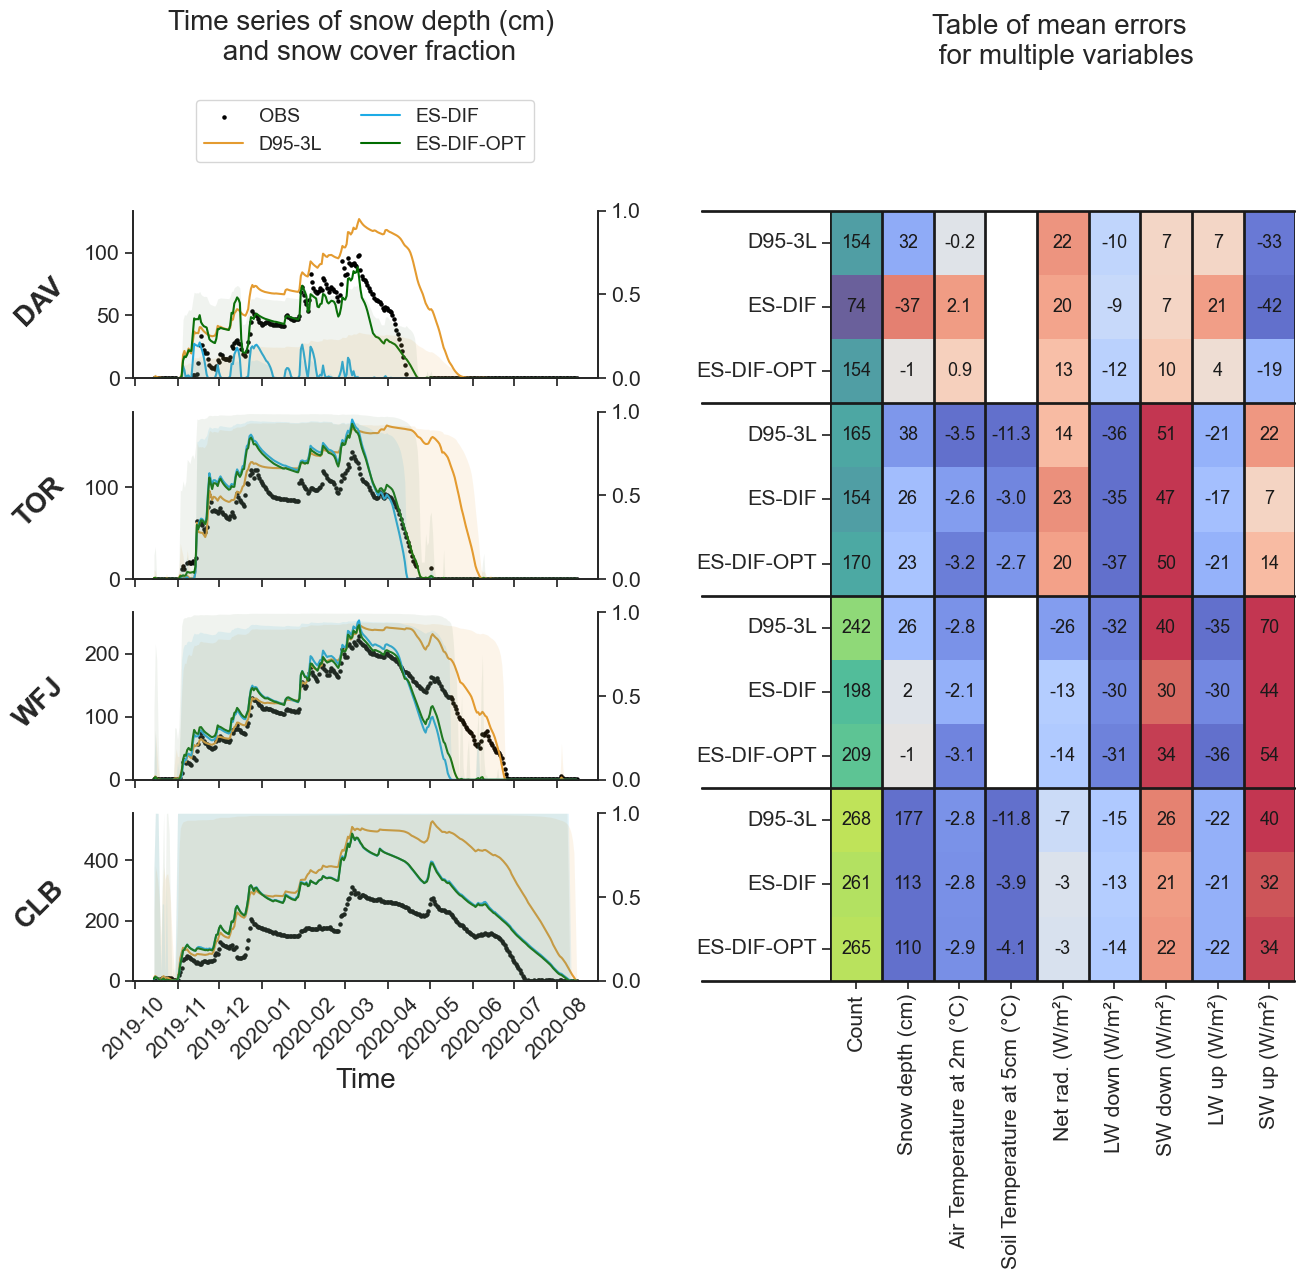

In [127]:
import matplotlib.patches as mpatches
import numpy.ma as ma
    
sns.set(font_scale = 1.4)
sns.set_style("ticks")

var_name = {'snd':'Snow depth (cm)', 'snct' :'Snow cover fraction','tas':'Temperature at 2m (°C)','rtot': 'Net radiation (W/m²)'}
var = ['snd']

fig, ax = plt.subplots(len(list(ls_station.keys())),2, figsize = (15,10), sharex = True)

for i in range(0,len(list(ls_station.keys()))):
    for j in range(0,len(var)):

        ax[i,0].scatter(ds_point['OBS'].time,ds_point['OBS'][var[j]].sel(Station_Name = list(ls_station.keys())[i]), color = ls_name_color['OBS'], s = 5, label = 'OBS', zorder = 10)
        
        for k in ls_EXPE:
            ls_name_color = {'MODIS':'gray','CSNOW':'gray','OBS':'black','D95_3L':"#e49b30",'ES_DIFF':"#1dabe6",'ES_DIFF_UP_PATCH':'#79c08a','ES_DIFF_UP_PATCH_GFLUX':'#ab50d8','ES_DIFF_UP_PATCH_GFLUX_WSN1':'#865e52','ES_DIFF_sg_LSOC_PATCH':'#006c00','ES_DIFF_OPT_RIL':'darkgrey'}
            ax[i,0].plot(ds_point[k].time,ds_point[k][var[j]].sel(Station_Name = list(ls_station.keys())[i]), color = ls_name_color[k], lw = 1.5, label = ls_EXPE[k], zorder = 15)
        
        if var[j] == 'tas' or var[j] == 'rtot':        
            ax[i,0].axhline(y=0.0, color='k', linestyle=':', lw = 0.5)
            
        ax2 = ax[i,0].twinx()
        for k in ls_EXPE:
            # Call updated color for background in order to be less greeny
            ls_name_color = {'MODIS':'gray','CSNOW':'gray','OBS':'black','D95_3L':"#e49b30",'ES_DIFF':"#1dabe6",'ES_DIFF_UP_PATCH':'#79c08a','ES_DIFF_UP_PATCH_GFLUX':'#ab50d8','ES_DIFF_UP_PATCH_GFLUX_WSN1':'#865e52','ES_DIFF_sg_LSOC_PATCH':'#729167','ES_DIFF_OPT_RIL':'darkgrey'}
            ax2.fill_between(x = ds_point[k].time,y1 =ds_point[k]['snct'].sel(Station_Name = list(ls_station.keys())[i])*0,y2=ds_point[k]['snct'].sel(Station_Name = list(ls_station.keys())[i]) , color=ls_name_color[k], alpha=0.1, lw=0, zorder = 0)
        
        ax2.set_ylim(0,1)
        plt.xticks(rotation=70)
        ax[i,0].spines["top"].set_visible(False)
        ax2.spines["top"].set_visible(False)    

        for tick in ax[i,0].get_xticklabels():
            tick.set_rotation(45)

        if var[j] == 'snd':
            ax[i,0].set_ylim(0,None)

        handles, labels = ax[i,0].get_legend_handles_labels()

        ax[3,0].set_xlabel('Time', fontsize = 20)

        if j == 0:
            ax[i,0].set_ylabel(list(ls_station_abbrv.values())[i],rotation = 45, fontsize = 20,fontweight='bold')
            ax[i,0].yaxis.set_label_coords(-0.18,0.4)

ax[0,0].set_title('Time series of snow depth (cm) \n and snow cover fraction', fontsize = 20, y=1.85)
     
fig.legend(handles, labels, loc='upper center', ncol = 2,bbox_to_anchor=(0.28, 1.0), prop={'size': 14})

gs = ax[0, 1].get_gridspec()
for i in ax[:, 1:]:
    i[0].remove()
axbig = fig.add_subplot(gs[:, 1:])

fig.subplots_adjust(wspace=0.5)
# plt.savefig(output_path+'Panel_time_series_extensive_stations.pdf', bbox_inches ='tight')

## Treatment of the table

condition = 'Snow'
score = 'ME'

table = df[(df['Condition'] == condition) & (df['Scores'] == score)]

table = pd.pivot_table(table,values = ls_var, index = ['Station_Name','EXPE'])[ls_var]
table = table.reindex(list(ls_EXPE.values()), level = 1)
table = table.reindex(['Davos_meteoswiss','IT-Tor','Weissfluhjoch','CLB'],level = 0)

## Heatmap

if condition == 'No_Snow':
    table = table.drop(columns = 'snd')
    
for col in table:
    vmin = table[col].min()
    vmax = table[col].max()
    if score == 'ME':
        if col == 'tas' or col == 'tp3' or col == 'ts':
            cmap = 'coolwarm'
            vmin, vmax = -3.5,3.5
            fmt = '.1f'
        elif col == 'snd':
            cmap = 'coolwarm_r'
            vmin, vmax = -50,50
            fmt = '.0f'
        elif col == 'hfle' or col == 'hfsc' or col == 'rtot' or col == 'lwdn' or col == 'lwun' or col == 'swun' or col == 'swdn':
            cmap = 'coolwarm'
            vmin, vmax = -35,35 
            fmt = '.0f'
        elif col == 'counter': 
            cmap = 'viridis'
            vmin, vmax = 30,300
            fmt = '.0f'
            
    elif score == 'R2':
            cmap = 'viridis'
            vmin, vmax = 0,1
            fmt = '.2f'
            
            if col == 'counter': 
                cmap = 'viridis'
                vmin, vmax = 30,300
                fmt = '.0f'

    mask = table.copy()
    for col_m in mask:
        mask[col_m] = col != col_m

        
    sns.heatmap(data=table,
                annot=table.to_numpy(), annot_kws={'fontsize': '13','color':'k'}, fmt=fmt,
                mask=mask,
                cmap=cmap, vmin=vmin, vmax=vmax, cbar=False, ax=axbig, alpha = 0.8)
    
    # Vertical and horizontal lines to delimitate metrics and elevation bands
    ls_line = np.arange(0,(len(list(ls_EXPE.keys())))*(len(np.unique(table.index.get_level_values(0)))+1),(len(list(ls_EXPE.keys()))))
    xline = -2.8
    axbig.hlines(ls_line,xmin = -2.5,xmax = axbig.get_xlim()[-1], color ='k', lw = 1, clip_on=False)
    axbig.vlines(np.arange(0,len(ls_var)+1,1),*axbig.get_ylim(), color ='k', lw = 1)
    

    # Labels and titles
    axbig.set_ylabel('')
    axbig.set_yticklabels([x[1] for x in table.index.tolist()])
    axbig.set_xticklabels(['Count','Snow depth (cm)','Air Temperature at 2m (°C)','Soil Temperature at 5cm (°C)','Net rad. (W/m²)','LW down (W/m²)','SW down (W/m²)','LW up (W/m²)','SW up (W/m²)'], rotation = 90)
axbig.set_title('Table of mean errors \n for multiple variables', fontsize = 20, y=1.18)
plt.savefig(output_path+'Time_series_Table_scores_ME.pdf', bbox_inches ='tight')

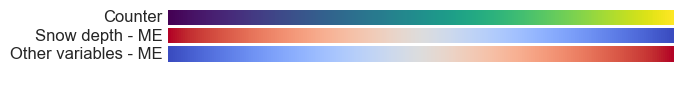

In [78]:
## Colormap legend for heatmap

import matplotlib as mpl
cmaps = {}

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
cmap_list=['viridis','coolwarm_r', 'coolwarm']
ls_name = ['Counter','Snow depth - ME','Other variables - ME']

# Create figure and adjust figure height to number of colormaps
nrows = len(cmap_list)
figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
fig, axs = plt.subplots(nrows=nrows + 1, figsize=(6.4, figh))
fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                    left=0.2, right=0.99)

for ax, name in zip(axs, cmap_list):
    ax.imshow(gradient, aspect='auto', cmap=mpl.colormaps[name])

for ax, name in zip(axs, ls_name):
    ax.text(-0.01, 0.5, name, va='center', ha='right', fontsize=12,
            transform=ax.transAxes)
    
# Turn off *all* ticks & spines, not just the ones with colormaps.
for ax in axs:
    ax.set_axis_off()

plt.savefig(output_path+'Colormap_for_table_heatmap.pdf', bbox_inches ='tight')